SPDX-License-Identifier: Apache-2.0 — See LICENSE for full terms
> Created by Patrick Woo, 2025  
> This file is part of the FPS-R (Frame-Persistent Stateless Randomisation) project.  
> https://github.com/patwooky/fpsr

# **FPS-R**

## **Frame-Persistent Stateless Randomisation**
**FPS-R** stands for **Frame-Persistent Stateless Randomisation**. It is a philosophy and framework behind a collection of lightweight algorithmic pattern for simulating persistent yet stateless randomness across a continuous timeline—ideal for procedural motion, glitch aesthetics, synthesised organic behaviour, and analogue artefact emulation.

### Algorithms
This notebook will provide the Python code for the following FPS-R Algorithms:
- **Stacked Modulo (SM)**
- **Toggled Modulo (TM)**
- **Quantised Switching (QS)**

In [99]:
# Created in Python 3.13.5
# import libraries
import os
import sys
import json
import time
import math
import random
import threading
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Add inline plotting for matplotlib
%matplotlib inline

### Helper Functions
These functions are support the FPS-R `fpsr_xx_base()` and `fpsr_xx_get_details()` functions

#### Helper Functions for Deterministic Operations
These helper functions ensure deterministic behavior across platforms and match the C reference implementation.

In [100]:
# Bit-width used for chunked bit operations. Must remain 64 for deterministic compatibility.
_CHUNK_BITS = 64

# 64-bit mask for emulating uint64_t wraparound exactly like C.
_UINT64_MASK = (1 << _CHUNK_BITS) - 1

def _to_uint64(x: int) -> int:
    """Cast any Python int to an emulated uint64_t by masking to 64 bits."""
    return x & _UINT64_MASK

def i64_floor_mod(a: int, m: int) -> int:
    """Return a modulo m using floor semantics, identical to Python's % for m>0."""
    return a % m

def i64_align_down(a: int, m: int) -> int:
    """Align a down to a multiple of m using floor-mod semantics."""
    return a - i64_floor_mod(a, m)

def _splitmix64(x: int) -> int:
    """SplitMix64: portable 64-bit mixer with well-defined unsigned wraparound."""
    x = _to_uint64(x + 0x9E3779B97F4A7C15)
    x = _to_uint64((x ^ (x >> 30)) * 0xBF58476D1CE4E5B9)
    x = _to_uint64((x ^ (x >> 27)) * 0x94D049BB133111EB)
    x = _to_uint64(x ^ (x >> 31))
    return x

def portable_rand_u64(seed: int) -> float:
    """Portable, deterministic PRNG that returns a double in [0,1)."""
    r = _splitmix64(_to_uint64(seed))
    return float((r >> 11)) * (1.0 / 9007199254740992.0)  # 2^53

def portable_rand(seed):
    """
    A simple, portable pseudo-random number generator.
    Generates a deterministic float between 0.0 and 1.0 from an integer-like seed.
    This wrapper forwards to a 64-bit deterministic PRNG that mirrors the C code.

    Args:
        seed (int|float): An integer-like seed. Floats are floored for determinism.

    Returns:
        float: A pseudo-random float between 0.0 and 1.0.
    """
    if isinstance(seed, float):
        seed = math.floor(seed)
    else:
        seed = int(seed)
    return portable_rand_u64(seed)

def _circular_left_shift(value: int, shift: int) -> int:
    """Performs a _CHUNK_BITS-wide circular left shift (rotate left)."""
    shift %= _CHUNK_BITS
    if shift == 0: return _to_uint64(value)
    return _to_uint64((value << shift) | (value >> (_CHUNK_BITS - shift)))

def _circular_right_shift(value: int, shift: int) -> int:
    """Performs a _CHUNK_BITS-wide circular right shift (rotate right)."""
    shift %= _CHUNK_BITS
    if shift == 0: return _to_uint64(value)
    return _to_uint64((value >> shift) | (value << (_CHUNK_BITS - shift)))

#### Sine Lookup Table (LUT) Implementation
Thread-safe, one-time initialization of sine lookup tables for use in fpsr_qs.

In [101]:
# -----------------------------------------------------------------------------
# Sine Lookup Table (LUT) Implementation
# -----------------------------------------------------------------------------
# This logic mirrors the C reference's thread-safe, one-time initialization
# of sine lookup tables for use in fpsr_qs.

_SINE_LUT_SIZE_100 = 100
_SINE_LUT_SIZE_500 = 500
_SINE_LUT_SIZE_1000 = 1000
_SINE_LUT_SIZE_4096 = 4096

_TWO_PI = 6.28318530718

# Global sine lookup tables (initialized as empty lists)
_sine_lut_100 = []
_sine_lut_500 = []
_sine_lut_1000 = []
_sine_lut_4096 = []

# Thread-safe initialization control (Python equivalent of C's 'init_once')
_sine_luts_initialized = False
_sine_luts_lock = threading.Lock()

def initialize_sine_luts():
    """
    Initializes all global sine lookup tables.
    This function is called exactly once by _init_once_func.
    """
    global _sine_lut_100, _sine_lut_500, _sine_lut_1000, _sine_lut_4096
    
    _sine_lut_100 = [math.sin(i / _SINE_LUT_SIZE_100 * _TWO_PI) for i in range(_SINE_LUT_SIZE_100)]
    _sine_lut_500 = [math.sin(i / _SINE_LUT_SIZE_500 * _TWO_PI) for i in range(_SINE_LUT_SIZE_500)]
    _sine_lut_1000 = [math.sin(i / _SINE_LUT_SIZE_1000 * _TWO_PI) for i in range(_SINE_LUT_SIZE_1000)]
    _sine_lut_4096 = [math.sin(i / _SINE_LUT_SIZE_4096 * _TWO_PI) for i in range(_SINE_LUT_SIZE_4096)]

def _init_once_func():
    """
    Ensures initialize_sine_luts() is called exactly once, in a thread-safe manner.
    """
    global _sine_luts_initialized
    # Double-checked locking pattern for efficiency
    if not _sine_luts_initialized:
        with _sine_luts_lock:
            if not _sine_luts_initialized:
                initialize_sine_luts()
                _sine_luts_initialized = True

def _get_sine_from_lod_lut(phase: float, lut_size: int, lut_array: list) -> float:
    """
    Gets a sine value from a specific LUT with linear interpolation.
    Matches the C reference implementation.
    """
    # 1. Guaranteed thread-safe call
    _init_once_func()

    # 2. Interpolation logic
    # Wrap phase to 0 to 2*PI range
    phase = phase % _TWO_PI
    if phase < 0:
        phase += _TWO_PI  # Ensure positive

    # Map phase to LUT index range
    fractional_index = (phase / _TWO_PI) * lut_size
    
    # Get integer part and fractional part
    index1 = math.floor(fractional_index)
    frac = fractional_index - index1
    
    # Handle wrap-around for index2 (last point wraps to first)
    index1 = int(index1)
    if index1 >= lut_size:
        index1 = 0
    index2 = (index1 + 1) % lut_size

    # Linear interpolation
    return lut_array[index1] * (1.0 - frac) + lut_array[index2] * frac

# Initialize the sine lookup tables immediately
initialize_sine_luts()
print(f"Sine LUTs initialized: {len(_sine_lut_100)}, {len(_sine_lut_500)}, {len(_sine_lut_1000)}, {len(_sine_lut_4096)} entries")

Sine LUTs initialized: 100, 500, 1000, 4096 entries


#### FPS-R Output Structure
Python class equivalent of the C FPSR_Output struct

In [102]:
class FPSR_Output:
    """
    This class holds the output of the FPS-R algorithms.
    Different LODs will return different sets of fields:
    - LOD 0: randVal
    - LOD 1: randVal, has_changed
    - LOD 2: randVal, has_changed, hold_progress, last_changed_frame, next_changed_frame,
             randVal_next_changed_frame, randStreams[2], selected_stream (for QS algorithm)
    """
    def __init__(self):
        self.randVal = 0.0
        self.has_changed = 0
        self.randVal_previous = 0.0
        self.hold_progress = 0.0
        self.last_changed_frame = 0
        self.next_changed_frame = 0
        self.randVal_next_changed_frame = 0.0
        # QS-specific fields
        self.randStreams = [0.0, 0.0]
        self.selected_stream_idx = 0

## FPS-R Base Functions

### FPS-R: Stacked Modulo (SM)

In [103]:
def fpsr_sm_base(frame, minHold, maxHold, reseedInterval, seedInner, seedOuter, finalRandSwitch=True):
    """
    (Pure implementation)
    Generates a persistent random value that holds for a calculated duration.
    This function uses a two-step process. First, it determines a random
    'hold duration'. Second, it generates a stable integer for that duration,
    which is then used as a seed to produce the final, held random value.

    Args:
        frame (int): The current frame or time input.
        minHold (int): The minimum duration (in frames) for a value to hold.
        maxHold (int): The maximum duration (in frames) for a value to hold.
        reseedInterval (int): The fixed interval at which a new hold duration is calculated.
        seedInner (int): An offset for the random duration calculation to create unique sequences.
        seedOuter (int): An offset for the final value calculation to create unique sequences.
        finalRandSwitch (bool): A flag that can turn off the final randomisation step.

    Returns:
        float: when finalRandSwitch is 0: randVal will be a whole number representing the currently held frame
               when finalRandSwitch is 1: A float value between 0.0 and 1.0 that remains constant for the held duration.
    """
    if reseedInterval < 1:
        reseedInterval = 1  # Prevent division by zero.

    reseed_anchor = int(seedInner + frame) - i64_floor_mod(int(frame), int(reseedInterval))
    rand_for_duration = portable_rand_u64(reseed_anchor)
    holdDuration = math.floor(float(minHold) + rand_for_duration * float(maxHold - minHold))

    if holdDuration < 1:
        holdDuration = 1  # Prevent division by zero.

    # --- 2. Generate the stable integer "state" for the hold period ---
    # This value is constant for the entire duration of the hold.
    held_integer_state = i64_align_down(int(seedOuter + frame), int(holdDuration))

    # --- 3. Use the stable state as a seed for the final random value (or bypass) ---
    # Because the seed is stable, the final value is also stable.
    if finalRandSwitch:
        fpsr_output = portable_rand_u64(held_integer_state)
    else:
        # If finalRandSwitch is false, we return the raw integer state directly.
        fpsr_output = float(held_integer_state)

    return fpsr_output

### FPS-R: Toggled Modulo (TM)

In [104]:
def fpsr_tm_base(frame, periodA, periodB, periodSwitch, seedInner, seedOuter, finalRandSwitch=True):
    """
    (Pure implementation)
    Generates a persistent value that holds for a rhythmically toggled duration.
    This function uses a deterministic switch to toggle the hold duration
    between two fixed periods.

    Args:
        frame (int): The current frame or time input.
        periodA (int): The first hold duration (in frames).
        periodB (int): The second hold duration (in frames).
        periodSwitch (int): The fixed interval at which the hold duration is toggled.
        seedInner (int): An offset for the toggle clock to de-sync it from the main clock.
        seedOuter (int): An offset for the main clock to create unique output sequences.
        finalRandSwitch (bool): A flag to enable/disable the final randomisation step.

    Returns:
        float: when finalRandSwitch is 0: An integer value representing the currently held frame state.
               when finalRandSwitch is 1: A float value between 0.0 and 1.0 that holds for the toggled duration.
    """
# --- 1. Determine the hold duration by toggling between two periods ---
    if periodSwitch < 1:
        periodSwitch = 1  # Prevent division by zero.

    # The "inner clock" is offset by seedInner to de-correlate it from the main frame.
    inner_clock_frame = seedInner + frame

    # The ternary switch: toggle between periodA and periodB at a fixed rhythm.
    if (inner_clock_frame % periodSwitch) < (periodSwitch * 0.5):
        holdDuration = periodA
    else:
        holdDuration = periodB

    if holdDuration < 1:
        holdDuration = 1  # Prevent division by zero.

    # --- 2. Generate the stable integer "state" for the hold period ---
    # The "outer clock" is offset by seedOuter to create unique output sequences.
    outer_clock_frame = seedOuter + frame
    held_integer_state = outer_clock_frame - (outer_clock_frame % holdDuration)

    # --- 3. Use the stable state as a seed for the final random value (or bypass) ---
    if finalRandSwitch:
        fpsr_output = portable_rand_u64(held_integer_state)
    else:
# If false, return the raw integer state directly.
        fpsr_output = float(held_integer_state)

    return fpsr_output

# end of fpsr_tm function

### FPS-R: Quantised Switching (QS)

In [105]:
def fpsr_qs_base(frame, baseWaveFreq, stream2FreqMult, quantLevelsMinMax, streamsOffset, quantOffsets,
                 streamSwitchDur, stream1QuantDur, stream2QuantDur, finalRandSwitch=True, sine_lod_level: int = 4):
    """
    (Pure implementation for wrapper)
    Generates a quantized sine-based persistent random value using two streams.
    This function creates two sine wave streams with configurable frequencies
    and offsets. For each stream, a new random quantisation level is chosen 
    from within the [min, max] range at a set interval, and the output alternates
    between the two streams based on a defined switch duration. The final output can
    optionally be further randomized.

    Args:
        frame (int): The current frame or time input.
        baseWaveFreq (float): The base frequency for the sine waves.
        stream2FreqMult (float): A multiplier for the second stream's frequency.
        quantLevelsMinMax (list[int]): A list [min, max] quantization levels.
        streamsOffset (list[int]): A list [offset1, offset2] for each sine stream.
        quantOffsets (list[int]): A list [q_offset1, q_offset2] for each stream.
        streamSwitchDur (int): The duration (in frames) before switching between streams.
        stream1QuantDur (int): The quantization duration (in frames) for stream 1.
        stream2QuantDur (int): The quantization duration (in frames) for stream 2.
        finalRandSwitch (bool): A flag that can turn off the final randomisation step.
        sine_lod_level (int): Level of detail for sine calculation (0=direct, 1-4=LUTs).

    Returns:
        FPSR_Output: 
        A populated FPSR_Output object containing the randVal, randStreams, 
        and selected_stream_idx. Other LOD fields are not populated by this base function.
    """
    output = FPSR_Output()

    if streamSwitchDur < 1: streamSwitchDur = 1
    if stream1QuantDur < 1: stream1QuantDur = 1
    if stream2QuantDur < 1: stream2QuantDur = 1

    # --- 2. Calculate random quantisation levels for each stream ---
    quant_min = int(quantLevelsMinMax[0])
    quant_max = int(quantLevelsMinMax[1])
    quant_range = quant_max - quant_min + 1
    if quant_range < 1: quant_range = 1

    # --- Stream 1 Quant Level ---
    s1_quant_seed_aligned = i64_align_down(int(quantOffsets[0] + frame), stream1QuantDur)
    s1_rand_for_quant = portable_rand_u64(s1_quant_seed_aligned)
    s1_quant_level = quant_min + math.floor(s1_rand_for_quant * float(quant_range))

    # --- Stream 2 Quant Level ---
    s2_quant_seed_aligned = i64_align_down(int(quantOffsets[1] + frame), stream2QuantDur)
    s2_rand_for_quant = portable_rand_u64(s2_quant_seed_aligned)
    s2_quant_level = quant_min + math.floor(s2_rand_for_quant * float(quant_range))

    s1_quant_level = max(s1_quant_level, 1)
    s2_quant_level = max(s2_quant_level, 1)

    # --- 3. Generate the two quantised sine wave streams ---
    if stream2FreqMult <= 0: stream2FreqMult = 3.7

    angle1 = (float(streamsOffset[0]) + float(frame)) * float(baseWaveFreq)
    angle2 = (float(streamsOffset[1]) + float(frame)) * float(baseWaveFreq) * float(stream2FreqMult)
    
    stream1_raw_sine = 0.0
    stream2_raw_sine = 0.0
    
    if sine_lod_level == 0:
        stream1_raw_sine = math.sin(angle1)
        stream2_raw_sine = math.sin(angle2)
    elif sine_lod_level == 1:
        stream1_raw_sine = _get_sine_from_lod_lut(angle1, _SINE_LUT_SIZE_100, _sine_lut_100)
        stream2_raw_sine = _get_sine_from_lod_lut(angle2, _SINE_LUT_SIZE_100, _sine_lut_100)
    elif sine_lod_level == 2:
        stream1_raw_sine = _get_sine_from_lod_lut(angle1, _SINE_LUT_SIZE_500, _sine_lut_500)
        stream2_raw_sine = _get_sine_from_lod_lut(angle2, _SINE_LUT_SIZE_500, _sine_lut_500)
    elif sine_lod_level == 3:
        stream1_raw_sine = _get_sine_from_lod_lut(angle1, _SINE_LUT_SIZE_1000, _sine_lut_1000)
        stream2_raw_sine = _get_sine_from_lod_lut(angle2, _SINE_LUT_SIZE_1000, _sine_lut_1000)
    else: # Default to 4
        stream1_raw_sine = _get_sine_from_lod_lut(angle1, _SINE_LUT_SIZE_4096, _sine_lut_4096)
        stream2_raw_sine = _get_sine_from_lod_lut(angle2, _SINE_LUT_SIZE_4096, _sine_lut_4096)

    # Map sine from [-1,1] to [0,1] before quantizing
    output.randStreams[0] = math.floor((stream1_raw_sine * 0.5 + 0.5) * float(s1_quant_level)) / float(s1_quant_level)
    output.randStreams[1] = math.floor((stream2_raw_sine * 0.5 + 0.5) * float(s2_quant_level)) / float(s2_quant_level)

    # --- 4. Switch between the two streams ---
    r = i64_floor_mod(int(frame), streamSwitchDur)
    output.selected_stream_idx = 0 if (2 * r) < streamSwitchDur else 1
    active_stream_val = output.randStreams[output.selected_stream_idx]

    # --- 5. Hash the final output to create a random-looking value (or bypass) ---
    if finalRandSwitch:
        # Match the canonical C implementation's 'FIX'.
        # Scale the quantized value to preserve level information for hashing.
        hashed_int = math.floor(active_stream_val * 1000000.0)
        output.randVal = portable_rand_u64(hashed_int)
    else:
        # Match the canonical C implementation's 'FIX'.
        # Return the active_stream_val directly, which is already in the [0, 1] range.
        output.randVal = active_stream_val
        
    return output

### FPS-R: Bitwise Decode (BD)

In [106]:
def fpsr_bd_base(frame: int, block_size: int, streams_number: int = 1, streams_offset: int = 0,
                 intra_op: str = 'none', dynamic_shift_bits: int = 6, static_shift_amount: int = 1,
                 inter_op: str = 'xor', value_seed_offset: int = 0):
    """
    (Pure implementation)
    Generates a phrased random value by decoding a deterministically generated bitstream.

    Args:
        frame (int): The current frame or time input.
        block_size (int): The size of the macro-rhythm in frames. Must be > 0.
        streams_number (int): The number of parallel bitstreams to generate.
        streams_offset (int): The frame offset between each parallel stream's seed.
        intra_op (str): The unary (intra-stream) operation.
            Static ops: 'none', 'not', 'lshift', 'rshift', 'rotl', 'rotr'.
            Dynamic ops: 'lshift_dynamic', 'rshift_dynamic', 'rotl_dynamic', 'rotr_dynamic'.
        dynamic_shift_bits (int): For dynamic ops, the number of controller bits to read.
        static_shift_amount (int): For static ops, the fixed number of bits to shift/rotate.
        inter_op (str): The binary (inter-stream) operation. Options: 'xor', 'or', 'and'.
        value_seed_offset (int): An additional seed offset for the final value calculation.

    Returns:
        float: A deterministic, phrased pseudo-random double between 0.0 and 1.0.
    """
    if block_size <= 0:
        block_size = 1
    if streams_number < 1:
        streams_number = 1

    # Sanitize static_shift_amount to prevent Undefined Behavior
    sanitized_static_shift = static_shift_amount & (_CHUNK_BITS - 1)

    # --- Step 1: Find the Outer Anchor for the macro-block ---
    outer_anchor = i64_align_down(frame, block_size)

    # --- Step 2: Generate the raw bitstream(s) for the entire block ---
    num_chunks = (block_size + (_CHUNK_BITS - 1)) // _CHUNK_BITS
    raw_streams = []
    for i in range(streams_number):
        stream_seed = outer_anchor + (i * streams_offset)
        chunks = [_splitmix64(_to_uint64(int(stream_seed) + j)) for j in range(num_chunks)]
        raw_streams.append(chunks)

    # --- Step 3: Apply Intra-Stream Transformations ---
    transformed_streams = []
    unary_op = intra_op.lower()
    
    dynamic_ops = ['lshift_dynamic', 'rshift_dynamic', 'rotl_dynamic', 'rotr_dynamic']
    is_dynamic = unary_op in dynamic_ops

    if is_dynamic:
        num_transformed_streams = (streams_number // 2) + (streams_number % 2)
        for i in range(0, streams_number // 2):
            data_stream = raw_streams[i * 2]
            controller_stream = raw_streams[i * 2 + 1]
            
            max_bits_for_shift = 6 # ceil(log2(64))
            bit_mask_size = max(1, min(max_bits_for_shift, dynamic_shift_bits))
            bit_mask = (1 << bit_mask_size) - 1
            
            transformed_chunks = []
            for j in range(num_chunks):
                data_chunk = data_stream[j]
                controller_chunk = controller_stream[j]
                dynamic_shift = (controller_chunk & bit_mask)
                
                if unary_op == 'lshift_dynamic':
                    transformed_chunks.append(_to_uint64(data_chunk << (dynamic_shift % _CHUNK_BITS)))
                elif unary_op == 'rshift_dynamic':
                    transformed_chunks.append(_to_uint64(data_chunk >> (dynamic_shift % _CHUNK_BITS)))
                elif unary_op == 'rotl_dynamic':
                    transformed_chunks.append(_circular_left_shift(data_chunk, dynamic_shift))
                elif unary_op == 'rotr_dynamic':
                    transformed_chunks.append(_circular_right_shift(data_chunk, dynamic_shift))
            transformed_streams.append(transformed_chunks)
        
        if streams_number % 2 != 0:
            transformed_streams.append(raw_streams[-1]) # Copy last stream as-is

    else: # Apply static operations
        num_transformed_streams = streams_number
        for stream_chunks in raw_streams:
            if unary_op == 'not':
                transformed_chunks = [_to_uint64(~chunk) for chunk in stream_chunks]
            elif unary_op == 'lshift':
                transformed_chunks = [_to_uint64(chunk << sanitized_static_shift) for chunk in stream_chunks]
            elif unary_op == 'rshift':
                transformed_chunks = [_to_uint64(chunk >> sanitized_static_shift) for chunk in stream_chunks]
            elif unary_op == 'rotl':
                transformed_chunks = [_circular_left_shift(chunk, sanitized_static_shift) for chunk in stream_chunks]
            elif unary_op == 'rotr':
                transformed_chunks = [_circular_right_shift(chunk, sanitized_static_shift) for chunk in stream_chunks]
            else: # 'none'
                transformed_chunks = list(stream_chunks) # 'none', copy the stream
            transformed_streams.append(transformed_chunks)
        
    # --- Step 4: Combine Streams with Inter-Stream Operation ---
    if num_transformed_streams > 0:
        final_chunks = list(transformed_streams[0])
        op_map = { 'xor': (lambda a, b: a ^ b), 'or': (lambda a, b: a | b), 'and': (lambda a, b: a & b) }
        chosen_op = op_map.get(inter_op.lower(), lambda a, b: a ^ b) # Default to xor

        for i in range(1, num_transformed_streams):
            for j in range(num_chunks):
                final_chunks[j] = _to_uint64(chosen_op(final_chunks[j], transformed_streams[i][j]))
    else:
        final_chunks = [0] * num_chunks


    # --- Step 5: Decode the final bitstream ---
    # We define get_bit inside fpsr_bd so it has access to
    # final_chunks, num_chunks, and block_size from its closure.
    def get_bit(n):
        # Helper to get a specific bit, matching C's logic
        if not (0 <= n < block_size): return 0
        chunk_index = n // _CHUNK_BITS
        bit_index = n % _CHUNK_BITS
        if chunk_index >= num_chunks: return 0
        return (final_chunks[chunk_index] >> bit_index) & 1

    current_pos_in_block = frame - outer_anchor
    last_flip_pos = 0
    
    for i in range(current_pos_in_block, 0, -1):
        if get_bit(i) != get_bit(i - 1):
            last_flip_pos = i
            break
            
    # --- Step 6: Generate the final random value from the last bit-flip position ---
    final_seed = int(outer_anchor) + int(last_flip_pos) + int(value_seed_offset)
    
    return portable_rand_u64(final_seed)

## FPS-R `get_details()` Functions
These wrapper functions provide rich metadata using Hierarchical Phrased Quantisation (HPQ) logic and robust two-phase search.

### SM get_details()

In [107]:
def fpsr_sm_get_details(frame: int, frame_multiplier: float, minHold: int, maxHold: int,
                        reseedInterval: int, seedInner: int, seedOuter: int, finalRandSwitch: bool,
                        lod: int, max_search_frames: int, seg_block_length: int) -> FPSR_Output:
    """
    ---- SM: Stacked Modulo Wrapper with Details ----
    Wrapper for fpsr_sm that returns a detailed FPSR_Output struct.

    [PORT]: Ported from C docstring for fpsr_sm_get_details.

    Args:
        frame (int): The current frame or time input.
        frame_multiplier (float): The time scaling factor.
            < 1.0 = Slow-Motion (Time Stretch)
            = 1.0 = Normal Speed
            > 1.0 = Fast-Motion (Time Compression)
        minHold (int): Algorithm parameter.
        maxHold (int): Algorithm parameter.
        reseedInterval (int): Algorithm parameter.
        seedInner (int): Algorithm parameter.
        seedOuter (int): Algorithm parameter.
        finalRandSwitch (bool): Algorithm parameter.
        lod (int): The level of detail to calculate.
        max_search_frames (int): A safety limit for the backward/forward search.
        seg_block_length (int): The "runway" length for HPQ logic.

    Returns:
        FPSR_Output: A struct with metadata populated based on the LOD.
    """
    out = FPSR_Output()
    
    # --- HPQ Timeline Definitions ---
    # 1. "Application Timeline": The user's `frame` (e.g., 0, 1, 2...).
    # 2. "Content Timeline": The *original* algorithm's timeline.
    # `frame_multiplier` (fm) maps between them:
    # (Application Timeline Frame) * fm = (Content Timeline Frame)
    
    # Sanitize frame_multiplier (now "playback_speed")
    fm = 1.0 if frame_multiplier == 0.0 else frame_multiplier

    # --- (START) HIERARCHICAL PHRASED QUANTISATION (HPQ) LOGIC ---
    
    # --- 1. Find coordinate on "Content Timeline" ---
    # This calculation now matches the intuitive "playback_speed" convention.
    scaled_frame_position = float(frame) * fm
    master_frame = math.floor(scaled_frame_position)

    # --- 2. Find "Start Line" on "Application Timeline" ---
    # This finds the *first* application frame that maps to this master_frame.
    master_frame_start_app_frame = math.ceil(float(master_frame) / fm)

    # --- 3. Calculate Local Coordinates (all on "Application Timeline") ---
    # How many application frames has it been since this master_frame began?
    app_frames_into_gap = frame - master_frame_start_app_frame
    segment_index = 0
    local_progress_in_segment = 0

    if seg_block_length > 0:
        # Note: Python's // and % handle negatives with floor semantics,
        # which matches the C `i64_floor_mod` and `i64_align_down` logic.
        segment_index = app_frames_into_gap // seg_block_length
        local_progress_in_segment = app_frames_into_gap % seg_block_length
    
    # --- 4. Execute Two-Mode Logic ---
    if segment_index == 0:
        # --- MODE 1: "Tape Varispeed" (Anchor) ---
        # Repeat the value of the `master_frame` from the Content Timeline.
        out.randVal = float(fpsr_sm_base(master_frame, int(minHold), int(maxHold), int(reseedInterval), int(seedInner), int(seedOuter), finalRandSwitch))
    else:
        # --- MODE 2: "Telescopic Extension" (Generative Phrase) ---
        gap_seed = _splitmix64(_to_uint64(int(master_frame) + int(segment_index)))
        
        # Call using `local_progress_in_segment` (from Application Timeline)
        # and inject the unique `gap_seed` as 'seedInner'.
        out.randVal = float(fpsr_sm_base(local_progress_in_segment, int(minHold), int(maxHold), int(reseedInterval), int(gap_seed), int(seedOuter), finalRandSwitch))
    # --- (END) HIERARCHICAL PHRASED QUANTISATION (HPQ) LOGIC ---
    
    if lod < 1: return out

    # LOD 1: Compare with previous frame to check for change.
    # This call is on the "Application Timeline".
    prev_out = fpsr_sm_get_details(frame - 1, frame_multiplier, minHold, maxHold, reseedInterval, seedInner, seedOuter, finalRandSwitch, 0, 0, seg_block_length)
    out.randVal_previous = prev_out.randVal
    out.has_changed = 1 if (out.randVal != prev_out.randVal) else 0

    if lod < 2: return out

    # --- LOD 2: MODIFIED Robust Two-Phase Search ---
    # The search logic operates entirely on the "Application Timeline".
    next_val_candidate = 0.0
    step_int = 1

    # --- Backwards Search for last_changed_frame (on Application Timeline) ---
    if out.has_changed:
        out.last_changed_frame = int(frame)
    else:
        # Exponential probe backwards
        bound_low_int = frame
        step_int = 1
        while (frame - step_int > frame - max_search_frames):
            val_at_probe = fpsr_sm_get_details(frame - step_int, frame_multiplier, minHold, maxHold, reseedInterval, seedInner, seedOuter, finalRandSwitch, 0, 0, seg_block_length).randVal
            if (val_at_probe != out.randVal):
                bound_low_int = frame - step_int
                break
            bound_low_int = frame - step_int
            step_int *= 2
        
        # Binary search
        low_int = bound_low_int
        high_int = frame
        result_int = frame - max_search_frames + 1
        while(low_int <= high_int):
            mid_int = low_int + (high_int - low_int) // 2
            mid_val = fpsr_sm_get_details(mid_int, frame_multiplier, minHold, maxHold, reseedInterval, seedInner, seedOuter, finalRandSwitch, 0, 0, seg_block_length).randVal
            if (mid_val == out.randVal):
                prev_mid_val = fpsr_sm_get_details(mid_int - 1, frame_multiplier, minHold, maxHold, reseedInterval, seedInner, seedOuter, finalRandSwitch, 0, 0, seg_block_length).randVal
                if (prev_mid_val != out.randVal):
                    result_int = mid_int
                    break
                high_int = mid_int - 1
            else:
                low_int = mid_int + 1
        out.last_changed_frame = int(result_int)

    # --- Forwards Search for next_changed_frame (on Application Timeline) ---
    # Exponential probe forwards
    bound_high_int = frame
    step_int = 1
    while (frame + step_int < frame + max_search_frames):
        val_at_probe = fpsr_sm_get_details(frame + step_int, frame_multiplier, minHold, maxHold, reseedInterval, seedInner, seedOuter, finalRandSwitch, 0, 0, seg_block_length).randVal
        if (val_at_probe != out.randVal):
            bound_high_int = frame + step_int
            next_val_candidate = val_at_probe
            break
        bound_high_int = frame + step_int
        step_int *= 2
    
    # Binary search
    low_int = frame
    high_int = bound_high_int
    result_int = frame + max_search_frames
    while(low_int <= high_int):
        mid_int = low_int + (high_int - low_int) // 2
        mid_val = fpsr_sm_get_details(mid_int, frame_multiplier, minHold, maxHold, reseedInterval, seedInner, seedOuter, finalRandSwitch, 0, 0, seg_block_length).randVal
        if (mid_val != out.randVal):
            result_int = mid_int
            next_val_candidate = mid_val
            high_int = mid_int - 1
        else:
            low_int = mid_int + 1
    out.next_changed_frame = int(result_int)
    out.randVal_next_changed_frame = float(next_val_candidate)
    
    # --- (START) REPLACEMENT: UPDATED hold_progress Calculation ---
    # This calculation is now performed *purely* on the "Application Timeline"
    hold_duration_app_frames = float(out.next_changed_frame) - float(out.last_changed_frame)
    if (hold_duration_app_frames > 0.0):
        out.hold_progress = float((float(frame) - float(out.last_changed_frame)) / hold_duration_app_frames)
    else:
        out.hold_progress = 0.0
    # --- (END) REPLACEMENT: UPDATED hold_progress Calculation ---
    
    return out

### TM get_details()

In [108]:
def fpsr_tm_get_details(frame: int, frame_multiplier: float, periodA: int, periodB: int,
                        periodSwitch: int, seedInner: int, seedOuter: int, finalRandSwitch: bool,
                        lod: int, max_search_frames: int, seg_block_length: int) -> FPSR_Output:
    """
    ---- TM: Toggle Modulo Wrapper with Details ----
    Wrapper for fpsr_tm that returns a detailed FPSR_Output struct.

    [PORT]: Ported from C docstring for fpsr_tm_get_details.

    Args:
        frame (int): The current frame or time input.
        frame_multiplier (float): The time scaling factor.
            < 1.0 = Slow-Motion (Time Stretch)
            = 1.0 = Normal Speed
            > 1.0 = Fast-Motion (Time Compression)
        periodA (int): Algorithm parameter.
        periodB (int): Algorithm parameter.
        periodSwitch (int): Algorithm parameter.
        seedInner (int): Algorithm parameter.
        seedOuter (int): Algorithm parameter.
        finalRandSwitch (bool): Algorithm parameter.
        lod (int): The level of detail to calculate.
        max_search_frames (int): A safety limit for the backward/forward search.
        seg_block_length (int): The "runway" length for HPQ logic.

    Returns:
        FPSR_Output: A struct with metadata populated based on the LOD.
    """
    out = FPSR_Output()
    
    # Sanitize frame_multiplier
    fm = 1.0 if frame_multiplier == 0.0 else frame_multiplier

    # --- (START) HIERARCHICAL PHRASED QUANTISATION (HPQ) LOGIC ---
    
    # --- 1. Find coordinate on "Content Timeline" ---
    scaled_frame_position = float(frame) * fm
    master_frame = math.floor(scaled_frame_position)

    # --- 2. Find "Start Line" on "Application Timeline" ---
    # This finds the *first* application frame that maps to this master_frame.
    master_frame_start_app_frame = math.ceil(float(master_frame) / fm)

    # --- 3. Calculate Local Coordinates (all on "Application Timeline") ---
    app_frames_into_gap = frame - master_frame_start_app_frame
    segment_index = 0
    local_progress_in_segment = 0
    
    if seg_block_length > 0:
        segment_index = app_frames_into_gap // seg_block_length
        local_progress_in_segment = app_frames_into_gap % seg_block_length

    # --- 4. Execute Two-Mode Logic ---
    if segment_index == 0:
        # --- MODE 1: "Tape Varispeed" (Anchor) ---
        out.randVal = float(fpsr_tm_base(master_frame, int(periodA), int(periodB), int(periodSwitch), int(seedInner), int(seedOuter), finalRandSwitch))
    else:
        # --- MODE 2: "Telescopic Extension" (Generative Phrase) ---
        gap_seed = _splitmix64(_to_uint64(int(master_frame) + int(segment_index)))
        # Inject the unique `gap_seed` as 'seedInner'.
        out.randVal = float(fpsr_tm_base(local_progress_in_segment, int(periodA), int(periodB), int(periodSwitch), int(gap_seed), int(seedOuter), finalRandSwitch))
    # --- (END) HIERARCHICAL PHRASED QUANTISATION (HPQ) LOGIC ---
    
    if lod < 1: return out

    # LOD 1
    prev_out = fpsr_tm_get_details(frame - 1, frame_multiplier, periodA, periodB, periodSwitch, seedInner, seedOuter, finalRandSwitch, 0, 0, seg_block_length)
    out.randVal_previous = prev_out.randVal
    out.has_changed = 1 if (out.randVal != prev_out.randVal) else 0
    
    if lod < 2: return out

    # --- LOD 2: MODIFIED Robust Search (on Application Timeline) ---
    next_val_candidate = 0.0
    step_int = 1

    # --- Backwards Search for last_changed_frame ---
    if out.has_changed:
        out.last_changed_frame = int(frame)
    else:
        # Exponential probe backwards
        bound_low_int = frame
        step_int = 1
        while (frame - step_int > frame - max_search_frames):
            val_at_probe = fpsr_tm_get_details(frame - step_int, frame_multiplier, periodA, periodB, periodSwitch, seedInner, seedOuter, finalRandSwitch, 0, 0, seg_block_length).randVal
            if (val_at_probe != out.randVal):
                bound_low_int = frame - step_int
                break
            bound_low_int = frame - step_int
            step_int *= 2
        
        # Binary search
        low_int = bound_low_int
        high_int = frame
        result_int = frame - max_search_frames + 1
        while(low_int <= high_int):
            mid_int = low_int + (high_int - low_int) // 2
            mid_val = fpsr_tm_get_details(mid_int, frame_multiplier, periodA, periodB, periodSwitch, seedInner, seedOuter, finalRandSwitch, 0, 0, seg_block_length).randVal
            if (mid_val == out.randVal):
                prev_mid_val = fpsr_tm_get_details(mid_int - 1, frame_multiplier, periodA, periodB, periodSwitch, seedInner, seedOuter, finalRandSwitch, 0, 0, seg_block_length).randVal
                if (prev_mid_val != out.randVal):
                    result_int = mid_int
                    break
                high_int = mid_int - 1
            else:
                low_int = mid_int + 1
        out.last_changed_frame = int(result_int)

    # --- Forwards Search for next_changed_frame (on Application Timeline) ---
    # Exponential probe forwards
    bound_high_int = frame
    step_int = 1
    while (frame + step_int < frame + max_search_frames):
        val_at_probe = fpsr_tm_get_details(frame + step_int, frame_multiplier, periodA, periodB, periodSwitch, seedInner, seedOuter, finalRandSwitch, 0, 0, seg_block_length).randVal
        if (val_at_probe != out.randVal):
            bound_high_int = frame + step_int
            next_val_candidate = val_at_probe
            break
        bound_high_int = frame + step_int
        step_int *= 2
    
    # Binary search
    low_int = frame
    high_int = bound_high_int
    result_int = frame + max_search_frames
    while(low_int <= high_int):
        mid_int = low_int + (high_int - low_int) // 2
        mid_val = fpsr_tm_get_details(mid_int, frame_multiplier, periodA, periodB, periodSwitch, seedInner, seedOuter, finalRandSwitch, 0, 0, seg_block_length).randVal
        if (mid_val != out.randVal):
            result_int = mid_int
            next_val_candidate = mid_val
            high_int = mid_int - 1
        else:
            low_int = mid_int + 1
    out.next_changed_frame = int(result_int)
    out.randVal_next_changed_frame = float(next_val_candidate)
    
    # --- UPDATED hold_progress Calculation ---
    # This calculation is now performed *purely* on the "Application Timeline"
    hold_duration_app_frames = float(out.next_changed_frame) - float(out.last_changed_frame)
    if (hold_duration_app_frames > 0.0):
        out.hold_progress = float((float(frame) - float(out.last_changed_frame)) / hold_duration_app_frames)
    else:
        out.hold_progress = 0.0

    return out

### QS get_details()

In [109]:
def fpsr_qs_get_details(frame: int, frame_multiplier: float, baseWaveFreq: float, stream2FreqMult: float,
                        quantLevelsMinMax: list, streamsOffset: list, quantOffsets: list,
                        streamSwitchDur: int, stream1QuantDur: int, stream2QuantDur: int, finalRandSwitch: bool,
                        sine_lod_level: int, lod: int, max_search_frames: int, seg_block_length: int) -> FPSR_Output:
    """
    ---- QS: Quantised Switching Wrapper with Details ----
    Wrapper for fpsr_qs that returns a detailed FPSR_Output struct.

    [PORT]: Ported from C docstring for fpsr_qs_get_details.

    Args:
        frame (int): The current frame or time input.
        frame_multiplier (float): The time scaling factor.
            < 1.0 = Slow-Motion (Time Stretch)
            = 1.0 = Normal Speed
            > 1.0 = Fast-Motion (Time Compression)
        baseWaveFreq (float): Algorithm parameter.
        stream2FreqMult (float): Algorithm parameter.
        quantLevelsMinMax (list[int]): Algorithm parameter.
        streamsOffset (list[int]): Algorithm parameter.
        quantOffsets (list[int]): Algorithm parameter.
        streamSwitchDur (int): Algorithm parameter.
        stream1QuantDur (int): Algorithm parameter.
        stream2QuantDur (int): Algorithm parameter.
        finalRandSwitch (bool): Algorithm parameter.
        sine_lod_level (int): Algorithm parameter.
        lod (int): The level of detail to calculate.
        max_search_frames (int): A safety limit for the backward/forward search.
        seg_block_length (int): The "runway" length for HPQ logic.

    Returns:
        FPSR_Output: A struct with metadata populated based on the LOD.
    """
    
    # Sanitize frame_multiplier
    fm = 1.0 if frame_multiplier == 0.0 else frame_multiplier

    # --- (START) HIERARCHICAL PHRASED QUANTISATION (HPQ) LOGIC ---
    scaled_frame_position = float(frame) * fm
    master_frame = math.floor(scaled_frame_position)
    master_frame_start_app_frame = math.ceil(float(master_frame) / fm)

    app_frames_into_gap = frame - master_frame_start_app_frame
    segment_index = 0
    local_progress_in_segment = 0
    
    if seg_block_length > 0:
        segment_index = app_frames_into_gap // seg_block_length
        local_progress_in_segment = app_frames_into_gap % seg_block_length

    base_qs_output = None
    if segment_index == 0:
        # --- MODE 1: "Tape Varispeed" (Anchor) ---
        base_qs_output = fpsr_qs_base(master_frame, float(baseWaveFreq), float(stream2FreqMult), quantLevelsMinMax, streamsOffset, quantOffsets, int(streamSwitchDur), int(stream1QuantDur), int(stream2QuantDur), finalRandSwitch, sine_lod_level)
    else:
        # --- MODE 2: "Telescopic Extension" (Generative Phrase) ---
        gap_seed = _splitmix64(_to_uint64(int(master_frame) + int(segment_index)))
        
        # For QS, inject the unique seed into the 'quantOffsets'.
        new_quantOffsets = [
            quantOffsets[0] + int(_to_uint64(gap_seed) & 0xFFFFFFFF),
            quantOffsets[1] + int((_to_uint64(gap_seed) >> 32) & 0xFFFFFFFF)
        ]
        
        # Use `local_progress_in_segment` as the "frame"
        base_qs_output = fpsr_qs_base(local_progress_in_segment, float(baseWaveFreq), float(stream2FreqMult), quantLevelsMinMax, streamsOffset, new_quantOffsets, int(streamSwitchDur), int(stream1QuantDur), int(stream2QuantDur), finalRandSwitch, sine_lod_level)
    # --- (END) HIERARCHICAL PHRASED QUANTISATION (HPQ) LOGIC ---
    
    # Copy base results into the main output object
    out = base_qs_output

    if lod < 1: return out

    # LOD 1
    prev_out = fpsr_qs_get_details(frame - 1, frame_multiplier, baseWaveFreq, stream2FreqMult, quantLevelsMinMax, streamsOffset, quantOffsets, streamSwitchDur, stream1QuantDur, stream2QuantDur, finalRandSwitch, sine_lod_level, 0, 0, seg_block_length)
    out.randVal_previous = prev_out.randVal
    out.has_changed = 1 if (out.randVal != out.randVal_previous) else 0
    
    if lod < 2: return out

    # --- LOD 2: MODIFIED Robust Search (on Application Timeline) ---
    next_val_candidate = 0.0
    step_int = 1

    # --- Backwards Search for last_changed_frame ---
    if out.has_changed:
        out.last_changed_frame = int(frame)
    else:
        # Exponential probe backwards
        bound_low_int = frame
        step_int = 1
        while (frame - step_int > frame - max_search_frames): 
            probe_qs_output = fpsr_qs_get_details(frame - step_int, frame_multiplier, baseWaveFreq, stream2FreqMult, quantLevelsMinMax, streamsOffset, quantOffsets, streamSwitchDur, stream1QuantDur, stream2QuantDur, finalRandSwitch, sine_lod_level, 0, 0, seg_block_length)
            if (probe_qs_output.randVal != out.randVal):
                bound_low_int = frame - step_int
                break
            bound_low_int = frame - step_int
            step_int *= 2
        
        # Binary search
        low_int = bound_low_int
        high_int = frame
        result_int = frame - max_search_frames + 1
        while(low_int <= high_int):
            mid_int = low_int + (high_int - low_int) // 2
            mid_qs_output = fpsr_qs_get_details(mid_int, frame_multiplier, baseWaveFreq, stream2FreqMult, quantLevelsMinMax, streamsOffset, quantOffsets, streamSwitchDur, stream1QuantDur, stream2QuantDur, finalRandSwitch, sine_lod_level, 0, 0, seg_block_length)
            if (mid_qs_output.randVal == out.randVal):
                mid_minus_step_qs_output = fpsr_qs_get_details(mid_int - 1, frame_multiplier, baseWaveFreq, stream2FreqMult, quantLevelsMinMax, streamsOffset, quantOffsets, streamSwitchDur, stream1QuantDur, stream2QuantDur, finalRandSwitch, sine_lod_level, 0, 0, seg_block_length)
                if (mid_minus_step_qs_output.randVal != out.randVal):
                    result_int = mid_int
                    break
                high_int = mid_int - 1
            else:
                low_int = mid_int + 1
        out.last_changed_frame = int(result_int)

    # --- Forwards Search for next_changed_frame (on Application Timeline) ---
    # Exponential probe forwards
    bound_high_int = frame
    step_int = 1
    while (frame + step_int < frame + max_search_frames): 
        probe_qs_output = fpsr_qs_get_details(frame + step_int, frame_multiplier, baseWaveFreq, stream2FreqMult, quantLevelsMinMax, streamsOffset, quantOffsets, streamSwitchDur, stream1QuantDur, stream2QuantDur, finalRandSwitch, sine_lod_level, 0, 0, seg_block_length)
        if (probe_qs_output.randVal != out.randVal):
            bound_high_int = frame + step_int
            next_val_candidate = probe_qs_output.randVal
            break
        bound_high_int = frame + step_int
        step_int *= 2
    
    # Binary search
    low_int = frame
    high_int = bound_high_int
    result_int = frame + max_search_frames
    while(low_int <= high_int):
        mid_int = low_int + (high_int - low_int) // 2
        mid_qs_output = fpsr_qs_get_details(mid_int, frame_multiplier, baseWaveFreq, stream2FreqMult, quantLevelsMinMax, streamsOffset, quantOffsets, streamSwitchDur, stream1QuantDur, stream2QuantDur, finalRandSwitch, sine_lod_level, 0, 0, seg_block_length)
        if (mid_qs_output.randVal != out.randVal):
            result_int = mid_int
            next_val_candidate = mid_qs_output.randVal
            high_int = mid_int - 1
        else:
            low_int = mid_int + 1
    out.next_changed_frame = int(result_int)
    out.randVal_next_changed_frame = float(next_val_candidate)
    
    # --- UPDATED hold_progress Calculation ---
    # This calculation is now performed *purely* on the "Application Timeline"
    hold_duration_app_frames = float(out.next_changed_frame) - float(out.last_changed_frame)
    if (hold_duration_app_frames > 0.0):
        out.hold_progress = float((float(frame) - float(out.last_changed_frame)) / hold_duration_app_frames)
    else:
        out.hold_progress = 0.0

    return out

### BD get_details()

In [110]:
def fpsr_bd_get_details(frame: int, frame_multiplier: float, block_size: int, streams_number: int,
                        streams_offset: int, intra_op: str, dynamic_shift_bits: int, static_shift_amount: int,
                        inter_op: str, value_seed_offset: int, lod: int, max_search_frames: int,
                        seg_block_length: int) -> FPSR_Output:
    """
    ---- BD: Bitwise Decode Wrapper with Details ----
    Wrapper for fpsr_bd that returns a detailed FPSR_Output struct.

    [PORT]: Ported from C docstring for fpsr_bd_get_details.

    Args:
        frame (int): The current frame or time input.
        frame_multiplier (float): The time scaling factor.
            < 1.0 = Slow-Motion (Time Stretch)
            = 1.0 = Normal Speed
            > 1.0 = Fast-Motion (Time Compression)
        block_size (int): Algorithm parameter.
        streams_number (int): Algorithm parameter.
        streams_offset (int): Algorithm parameter.
        intra_op (str): Algorithm parameter.
        dynamic_shift_bits (int): Algorithm parameter.
        static_shift_amount (int): Algorithm parameter.
        inter_op (str): Algorithm parameter.
        value_seed_offset (int): Algorithm parameter.
        lod (int): The level of detail to calculate.
        max_search_frames (int): A safety limit for the backward/forward search.
        seg_block_length (int): The "runway" length for HPQ logic.

    Returns:
        FPSR_Output: A struct with metadata populated based on the LOD.
    """
    out = FPSR_Output()
    
    # Sanitize frame_multiplier
    fm = 1.0 if frame_multiplier == 0.0 else frame_multiplier

    # --- (START) HIERARCHICAL PHRASED QUANTISATION (HPQ) LOGIC ---
    scaled_frame_position = float(frame) * fm
    master_frame = math.floor(scaled_frame_position)
    master_frame_start_app_frame = math.ceil(float(master_frame) / fm)

    app_frames_into_gap = frame - master_frame_start_app_frame
    segment_index = 0
    local_progress_in_segment = 0

    if seg_block_length > 0:
        segment_index = app_frames_into_gap // seg_block_length
        local_progress_in_segment = app_frames_into_gap % seg_block_length

    if segment_index == 0:
        # --- MODE 1: "Tape Varispeed" (Anchor) ---
        out.randVal = float(fpsr_bd_base(master_frame, int(block_size), streams_number, int(streams_offset), intra_op, dynamic_shift_bits, static_shift_amount, inter_op, int(value_seed_offset)))
    else:
        # --- MODE 2: "Telescopic Extension" (Generative Phrase) ---
        gap_seed = _splitmix64(_to_uint64(int(master_frame) + int(segment_index)))
        
        # For BD, inject the unique seed as the 'value_seed_offset'.
        out.randVal = float(fpsr_bd_base(local_progress_in_segment, int(block_size), streams_number, int(streams_offset), intra_op, dynamic_shift_bits, static_shift_amount, inter_op, int(gap_seed)))
    # --- (END) HIERARCHICAL PHRASED QUANTISATION (HPQ) LOGIC ---
    
    if lod < 1: return out

    # LOD 1
    prev_out = fpsr_bd_get_details(frame - 1, frame_multiplier, block_size, streams_number, streams_offset, intra_op, dynamic_shift_bits, static_shift_amount, inter_op, value_seed_offset, 0, 0, seg_block_length)
    out.randVal_previous = prev_out.randVal
    out.has_changed = 1 if (out.randVal != out.randVal_previous) else 0

    if lod < 2: return out

    # --- LOD 2: MODIFIED Robust Search (on Application Timeline) ---
    next_val_candidate = 0.0
    step_int = 1

    # --- Backwards Search for last_changed_frame ---
    if out.has_changed:
        out.last_changed_frame = int(frame)
    else:
        # Exponential probe backwards
        bound_low_int = frame
        step_int = 1
        while (frame - step_int > frame - max_search_frames):
            val_at_probe = fpsr_bd_get_details(frame - step_int, frame_multiplier, block_size, streams_number, streams_offset, intra_op, dynamic_shift_bits, static_shift_amount, inter_op, value_seed_offset, 0, 0, seg_block_length).randVal
            if (val_at_probe != out.randVal):
                bound_low_int = frame - step_int
                break
            bound_low_int = frame - step_int
            step_int *= 2
        
        # Binary search
        low_int = bound_low_int
        high_int = frame
        result_int = frame - max_search_frames + 1
        while(low_int <= high_int):
            mid_int = low_int + (high_int - low_int) // 2
            mid_val = fpsr_bd_get_details(mid_int, frame_multiplier, block_size, streams_number, streams_offset, intra_op, dynamic_shift_bits, static_shift_amount, inter_op, value_seed_offset, 0, 0, seg_block_length).randVal
            if (mid_val == out.randVal):
                prev_mid_val = fpsr_bd_get_details(mid_int - 1, frame_multiplier, block_size, streams_number, streams_offset, intra_op, dynamic_shift_bits, static_shift_amount, inter_op, value_seed_offset, 0, 0, seg_block_length).randVal
                if (prev_mid_val != out.randVal):
                    result_int = mid_int
                    break
                high_int = mid_int - 1
            else:
                low_int = mid_int + 1
        out.last_changed_frame = int(result_int)

    # --- Forwards Search for next_changed_frame (on Application Timeline) ---
    # Exponential probe forwards
    bound_high_int = frame
    step_int = 1
    while (frame + step_int < frame + max_search_frames):
        val_at_probe = fpsr_bd_get_details(frame + step_int, frame_multiplier, block_size, streams_number, streams_offset, intra_op, dynamic_shift_bits, static_shift_amount, inter_op, value_seed_offset, 0, 0, seg_block_length).randVal
        if (val_at_probe != out.randVal):
            bound_high_int = frame + step_int
            next_val_candidate = val_at_probe
            break
        bound_high_int = frame + step_int
        step_int *= 2
    
    # Binary search
    low_int = frame
    high_int = bound_high_int
    result_int = frame + max_search_frames
    while(low_int <= high_int):
        mid_int = low_int + (high_int - low_int) // 2
        mid_val = fpsr_bd_get_details(mid_int, frame_multiplier, block_size, streams_number, streams_offset, intra_op, dynamic_shift_bits, static_shift_amount, inter_op, value_seed_offset, 0, 0, seg_block_length).randVal
        if (mid_val != out.randVal):
            result_int = mid_int
            next_val_candidate = mid_val
            high_int = mid_int - 1
        else:
            low_int = mid_int + 1
    out.next_changed_frame = int(result_int)
    out.randVal_next_changed_frame = float(next_val_candidate)

    # --- UPDATED hold_progress Calculation ---
    hold_duration_app_frames = float(out.next_changed_frame) - float(out.last_changed_frame)
    if (hold_duration_app_frames > 0.0):
        out.hold_progress = float((float(frame) - float(out.last_changed_frame)) / hold_duration_app_frames)
    else:
        out.hold_progress = 0.0

    return out

# FPS-R Plots

## FPS-R SM in a Sequence

In [111]:
# Define FPS-R SM in a Sequence using get_details()
def seq_sm(steps=1000):
    """
    Generates the stacked modulo sequence using get_details() for a given number of steps.

    Args:
        steps (int): The number of steps to simulate.
    """
    # Parameters for FPS-R:SM
    minHoldFrames = 13     # Minimum hold duration
    maxHoldFrames = 38     # Maximum hold duration
    reseedFrames = 54      # Reseed interval
    offsetInner = -24      # Inner seed offset
    offsetOuter = 123      # Outer seed offset
    frame_multiplier = 1.0 # 1.0 = normal speed
    max_search_frames = 50 # Safety limit for search
    seg_block_length = 5   # The "runway" length for HPQ logic

    values = []
    values_changed = []

    for frame in range(steps):
        output = fpsr_sm_get_details(frame, frame_multiplier, minHoldFrames, maxHoldFrames,
                                     reseedFrames, offsetInner, offsetOuter, True, 1, max_search_frames, seg_block_length)
        values.append(output.randVal)
        values_changed.append(output.has_changed)
    return [values, values_changed]

## FPS-R TM in a Sequence

In [112]:
# Define FPS-R TM in a Sequence using get_details()
def seq_tm(steps=1000):
    """
    Generates the toggled modulo sequence using get_details() for a given number of steps.

    Args:
        steps (int): The number of steps to simulate.
    """
    # Parameters for FPS-R:TM
    periodA = 10            # First hold duration
    periodB = 28            # Second hold duration
    periodSwitch = 33       # Period switch interval
    offsetInner = 15        # Inner seed offset
    offsetOuter = -7        # Outer seed offset
    frame_multiplier = 1.0  # Final randomisation switch
    max_search_frames = 50  # Safety limit for search
    seg_block_length = 5    # The "runway" length for HPQ logic

    values = []
    values_changed = []

    for frame in range(steps):
        output = fpsr_tm_get_details(frame, frame_multiplier, periodA, periodB, periodSwitch,
                                     offsetInner, offsetOuter, True, 1, max_search_frames, seg_block_length)
        values.append(output.randVal)
        values_changed.append(output.has_changed)

    return [values, values_changed]

## FPS-R QS in a Sequence

In [113]:
# Define FPS-R QS in a Sequence using get_details()
def seq_qs(steps=1000):
    """
    Generates the quantised switching sequence using get_details() for a given number of steps.

    Args:
        steps (int): The number of steps to simulate.
    """
    # Parameters for FPS-R:QS
    baseWaveFreq = 0.06     # Base wave frequency for stream 1
    stream2FreqMult = 0.025 # Frequency multiplier for stream 2
    quantLevelsMinMax = [4, 20] # Min and max quantisation levels
    streamsOffset = [0, 100] # Frame offsets for each stream
    quantOffsets = [-53, 150] # Quantisation level offsets
    streamSwitchDur = 32     # Duration after which streams switch
    stream1QuantDur = 27     # Duration for stream 1 quantisation hold
    stream2QuantDur = 25     # Duration for stream 2 quantisation hold
    sine_lod_level = 4       # Sine wave LOD level (0-4)
    frame_multiplier = 1.0   # Final randomisation switch
    max_search_frames = 50   # Safety limit for search
    seg_block_length = 5     # Segment block length for HPQ logic

    values = []
    values_changed = []

    for frame in range(steps):
        output = fpsr_qs_get_details(frame, frame_multiplier, baseWaveFreq, stream2FreqMult,
                                     quantLevelsMinMax, streamsOffset, quantOffsets, streamSwitchDur,
                                     stream1QuantDur, stream2QuantDur, True, sine_lod_level, 1, max_search_frames, seg_block_length)
        values.append(output.randVal)
        values_changed.append(output.has_changed)

    return [values, values_changed]

## FPS-R BD in a Sequence

In [114]:
# Define FPS-R BD in a Sequence using get_details()
def seq_bd(steps=1000):
    """
    Generates the bitwise decode sequence using get_details() for a given number of steps.

    Args:
        steps (int): The number of steps to simulate.
    """
    # Parameters for FPS-R:BD
    block_size = 30            # Size of the macro-rhythm block
    streams_number = 5         # Number of parallel bitstreams  
    streams_offset = 11        # Frame offset between each stream's seed
    # Intra-stream operation
    #      Static ops: "none", "not", "lshift", "rshift", "rotl", "rotr".
    #      Dynamic ops: "lshift_dynamic", "rshift_dynamic", "rotl_dynamic", "rotr_dynamic".
    intra_op = 'rotl_dynamic'  # Intra-stream operation on each stream
    dynamic_shift_bits = 6     # Dynamic shift bits for intra-op
    static_shift_amount = 1    # Static shift amount for intra-op
    # Inter-stream operation to combine transformed streams
    #     Options: "xor", "or", "and".    
    inter_op = 'or'            # Inter-stream operation
    value_seed_offset = 78901  # Additional seed offset for final value
    frame_multiplier = 1.0      # 1.0 = normal speed
    max_search_frames = 100     # Safety limit for search
    seg_block_length = 5       # The "runway" length for HPQ logic

    values = []
    values_changed = []

    for frame in range(steps):
        output = fpsr_bd_get_details(frame, frame_multiplier, block_size, streams_number,
                                     streams_offset, intra_op, dynamic_shift_bits, static_shift_amount,
                                     inter_op, value_seed_offset, 1, max_search_frames, seg_block_length)
        values.append(output.randVal)
        values_changed.append(output.has_changed)

    return [values, values_changed]

## Plot Value Graph Function

In [115]:
def plot_values(values, values_changed, seq_name='FPS-R Stacked Modulo'):
    """
    Plots the FPS-R Stacked Modulo output and the value change indicator.

    Args:
        values (list): List of FPS-R Stacked Modulo output values.
        values_changed (list): List indicating if the value has changed (1=changed, 0=unchanged).
    """
    label = f'{seq_name} Output'
    plt.figure(figsize=(20, 3))
    plt.plot(values, label=label, color='blue')
    plt.plot(values_changed, label='Value Changed (1=Changed, 0=Unchanged)', color='red', linestyle='--', alpha=0.5)
    plt.title(label)
    plt.xlabel('Frame')
    plt.ylabel('Output Value')
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()

## Held Steps Graph Function

In [116]:
def held_step_values(values, values_changed, seq_name='FPS-R Stacked Modulo'):
    """
    Plots the FPS-R Stacked Modulo output and the value change indicator.

    Args:
        values (list): List of FPS-R Stacked Modulo output values.
        values_changed (list): List indicating if the value has changed (1=changed, 0=unchanged).
    """
    label = f'{seq_name} Held Steps'
    plt.figure(figsize=(20, 3))
    plt.plot(values, label=label, color='blue')
    plt.plot(values_changed, label='Value Changed (1=Changed, 0=Unchanged)', color='red', linestyle='--', alpha=0.5)
    plt.title(label)
    plt.xlabel('Values Jump Count')
    plt.ylabel('No. of Held Steps')
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()

## Plot Distribution Graph Function

In [117]:
# create incremental steps of exponentials of 10
distri_progressive_steps = [10 ** x for x in range(6)][2:]
print(distri_progressive_steps)

[100, 1000, 10000, 100000]


In [118]:
# Exploratory Data Analysis on FPS-R SM
# distribution graph of returned values
def plot_distribution(seq_returns, seq_name='Untitled Function'):
    """
    Plots the distribution of values generated by a function.

    Args:
        seq_returns (list): List of values generated by a function.
        seq_name (str): Name of the sequence for the plot title.
    """
    plt.figure(figsize=(20, 2))
    plt.hist(seq_returns[0], bins=30, density=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {seq_name} Values Across {len(seq_returns[0])} Steps')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

## Function to Get a List of the Length of Each Hold

In [119]:
def held_steps_list(values_changed):
    """
    Counts the number of steps since the last change in the values_changed list.

    Args:
        values_changed (list): List indicating if the value has changed (1=changed, 0=unchanged).
    
    Returns:
        list: A list of the number of steps since the last change.
    """
    held_steps = []
    last_changed_index = -1
    for step, changed in enumerate(values_changed):
        if step == 0 and changed == 1:
            held_steps.append(1)
            last_changed_index = step
        elif changed == 1:
            held_steps.append(step - last_changed_index)
            last_changed_index = step
    return held_steps

## Plot Built-in `random.random()`

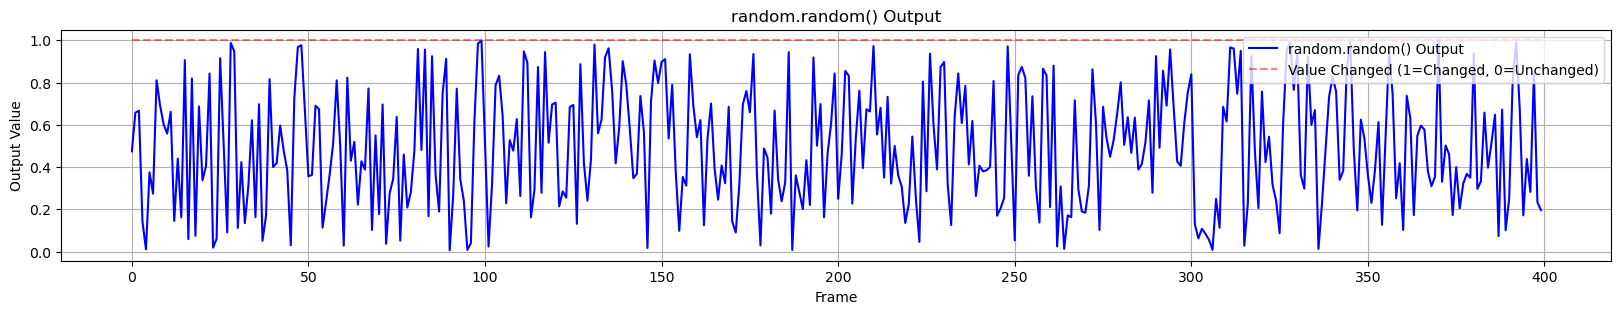

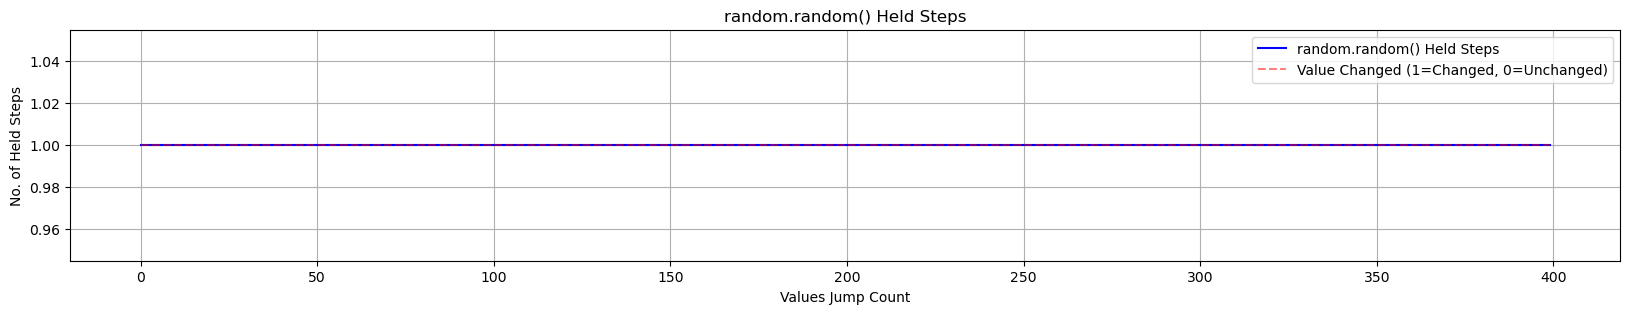

In [120]:
import random
random.seed(12)
values = [random.random() for x in range(400)]
values_changed = [1] * 400
plot_values(values, values_changed, seq_name='random.random()')

# output the changed steps list
held_steps = held_steps_list(values_changed)
# print(held_steps)
held_step_values(held_steps, [1]*len(held_steps), seq_name='random.random()')

All held steps are 1. This means that each changed value is held for exactly 1 frame. None of the values are held beyond a single frame.

## Plot `Portable_Rand()`

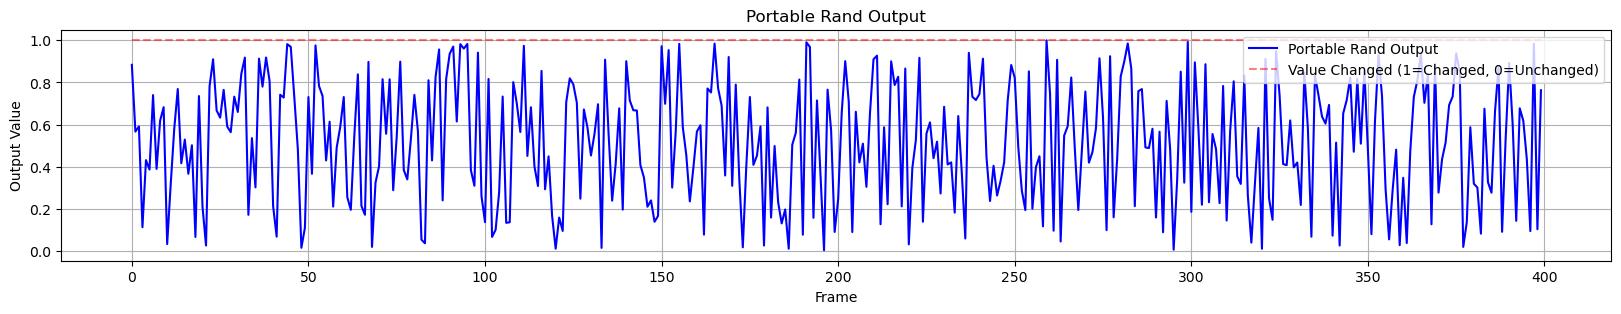

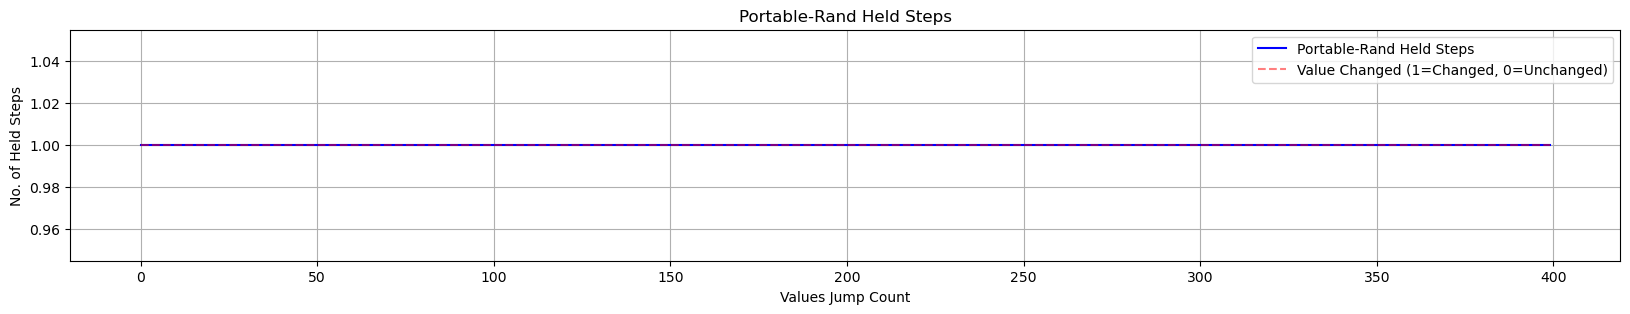

In [121]:
values = [portable_rand(x) for x in range(400)]
values_changed = [1] * 400
plot_values(values, values_changed, seq_name='Portable Rand')

# output the changed steps list
held_steps = held_steps_list(values_changed)
# print(held_steps)
held_step_values(held_steps, [1]*len(held_steps), seq_name='Portable-Rand')

All held steps are 1. This means that each changed value is held for exactly 1 frame. None of the values are held beyond a single frame.
This is similar to the behaviour of `random.random()`.

## Plot FPS-R SM

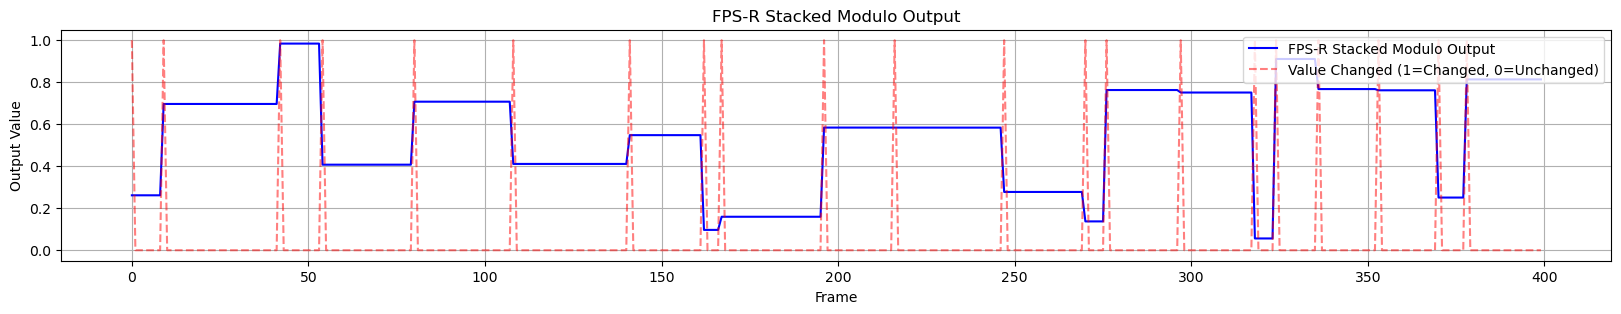

In [122]:
# calling fpsr_sm
values, values_changed = seq_sm(400)
# Plot the distribution of FPS-R SM values
plot_values(values, values_changed, seq_name='FPS-R Stacked Modulo')

FPS-R SM: Number of Steps Held Before the Next Jump

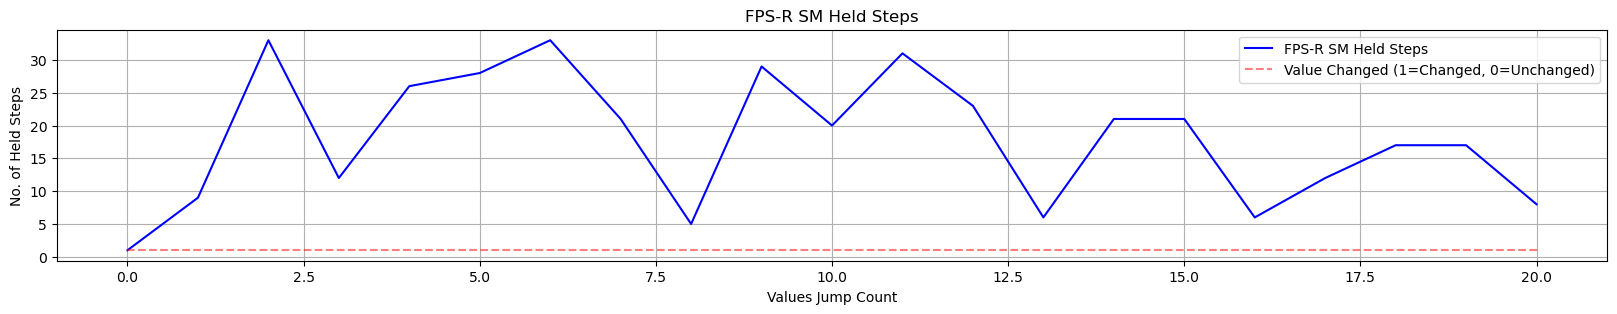

In [123]:
# output the changed steps list
held_steps = held_steps_list(values_changed)
# print(held_steps)
held_step_values(held_steps, [1]*len(held_steps), seq_name='FPS-R SM')

## Plot FPS-R SM Distribution Graphs

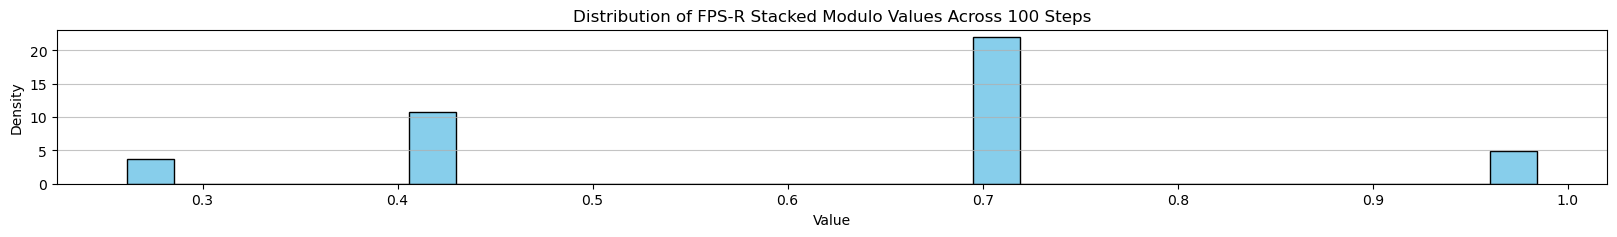

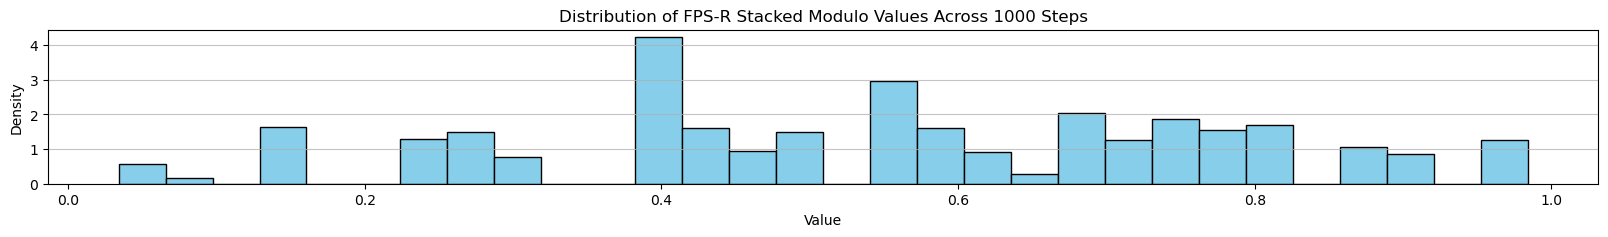

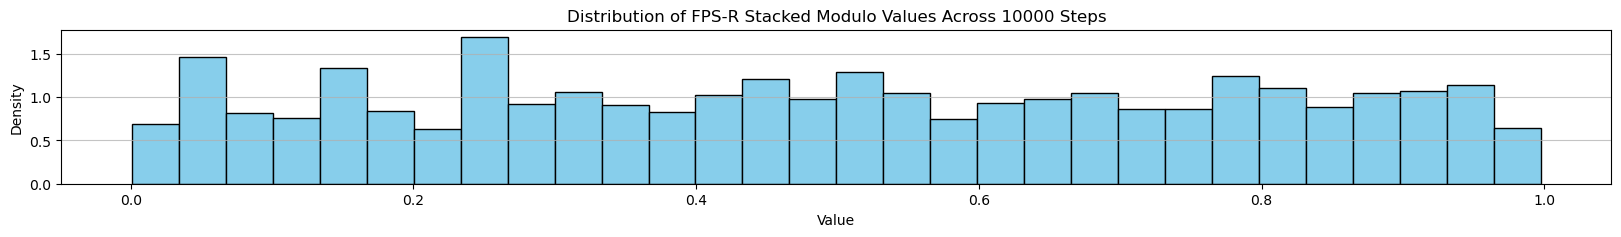

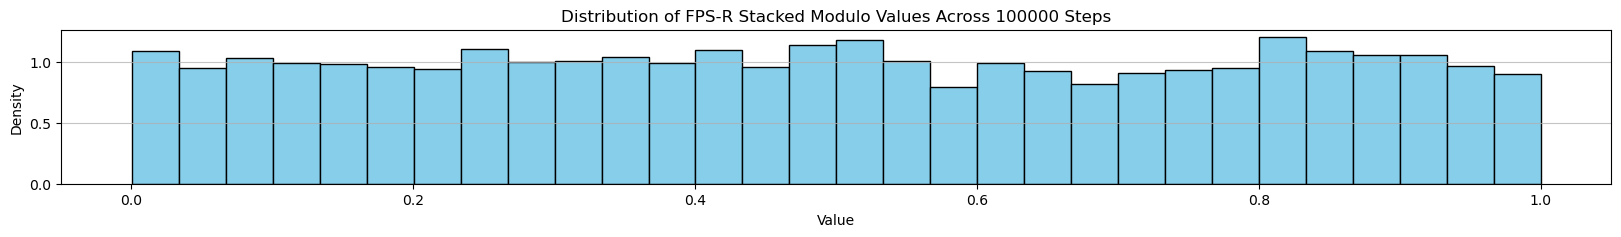

In [124]:
# Distribution Plot for SM
# seq_func points to the supplied function
seq_func = seq_sm
seq_name = 'FPS-R Stacked Modulo'

for frame_count in distri_progressive_steps:
    plot_distribution(seq_func(frame_count), seq_name)
# The distribution of FPS-R QS values show a consistent pattern across different sample sizes.

## Plot FPS-R TM

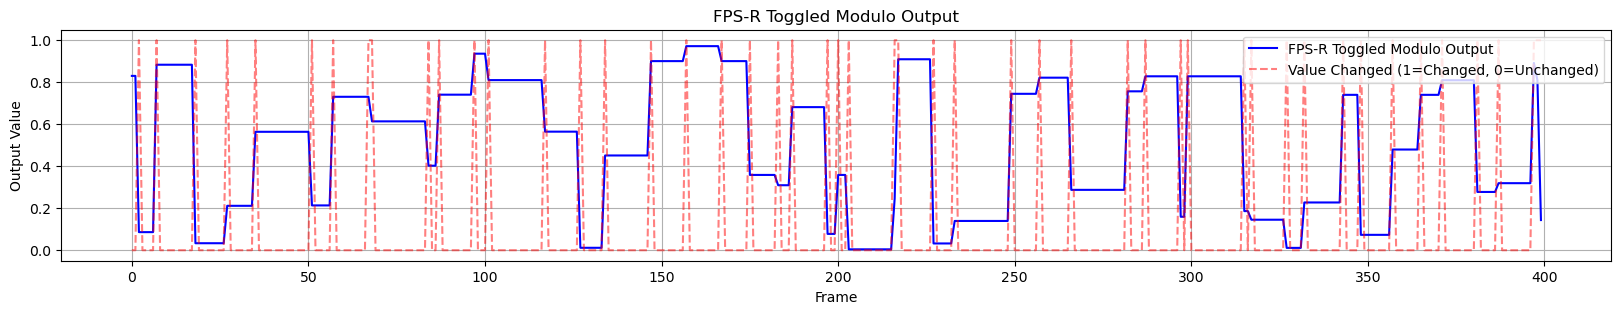

In [125]:
# calling fpsr_tm
values, values_changed = seq_tm(400)
# Plot the distribution of FPS-R TM values
plot_values(values, values_changed, seq_name='FPS-R Toggled Modulo')

FPS-R TM: Number of Steps Held Before the Next Jump

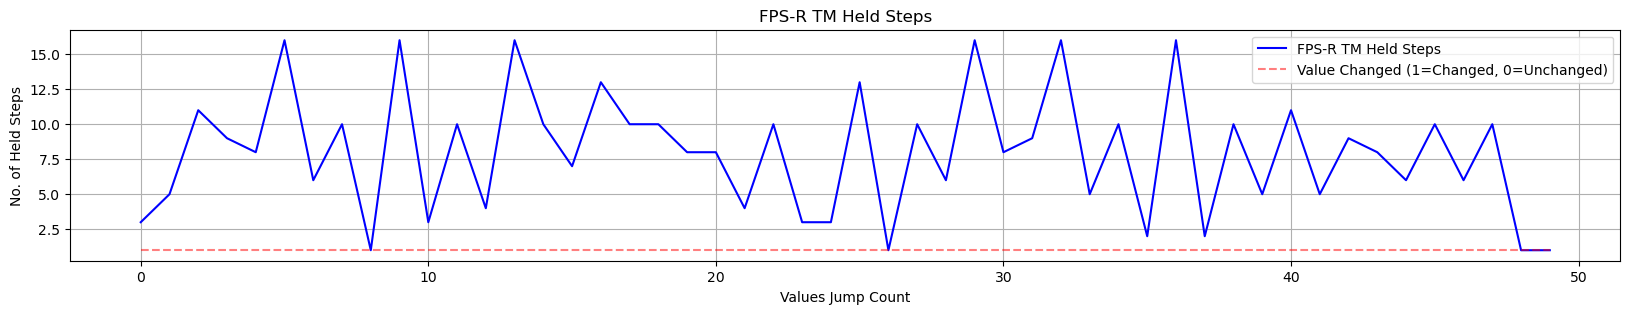

In [126]:
# output the changed steps list
held_steps = held_steps_list(values_changed)
# print(held_steps)
held_step_values(held_steps, [1]*len(held_steps), seq_name='FPS-R TM')

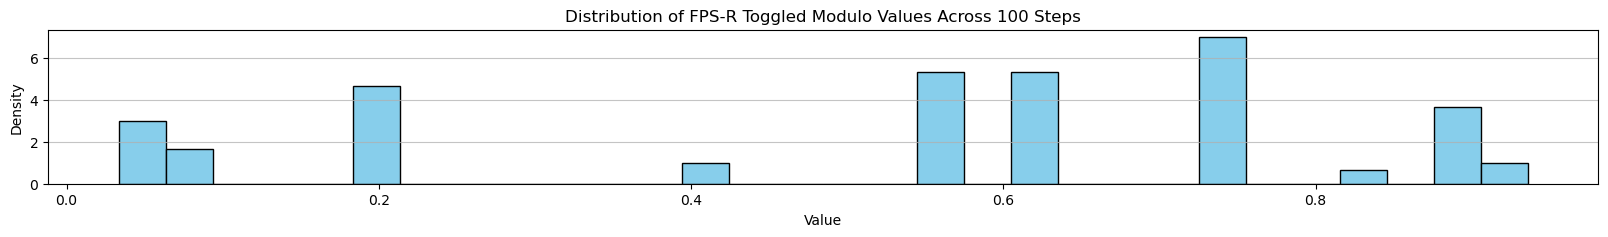

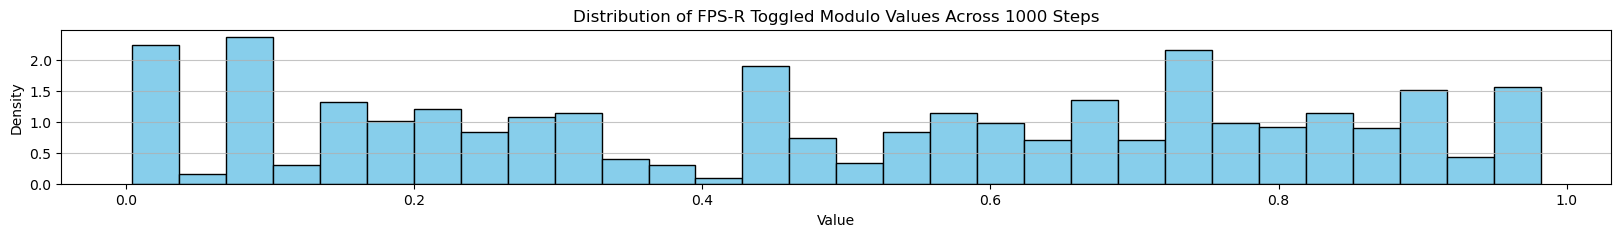

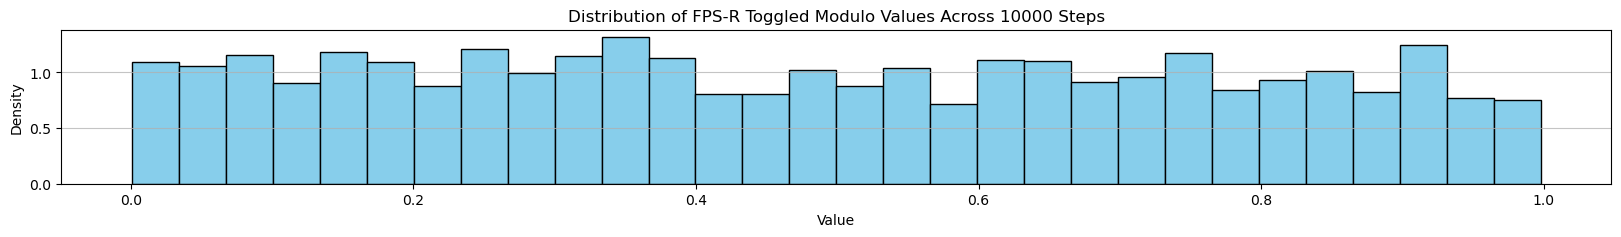

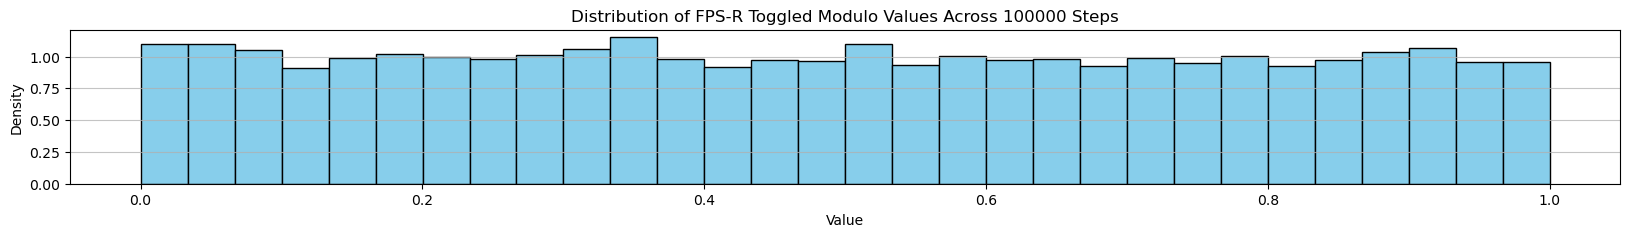

In [127]:
# Distribution Plot for TM
# seq_func points to the supplied function
seq_func = seq_tm
seq_name = 'FPS-R Toggled Modulo'

for frame_count in distri_progressive_steps:
    plot_distribution(seq_func(frame_count), seq_name)
# The distribution of FPS-R QS values show a consistent pattern across different sample sizes.

## Plot FPS-R QS

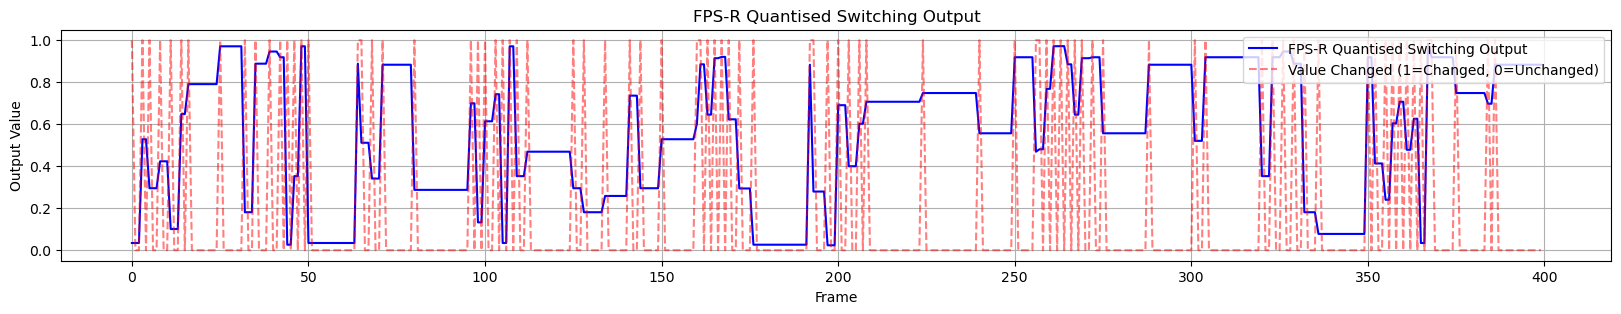

In [128]:
# calling fpsr_qs
values, values_changed = seq_qs(400)
# Plot the distribution of FPS-R QS values
plot_values(values, values_changed, seq_name='FPS-R Quantised Switching')

FPS-R QS: Number of Steps Held Before the Next Jump

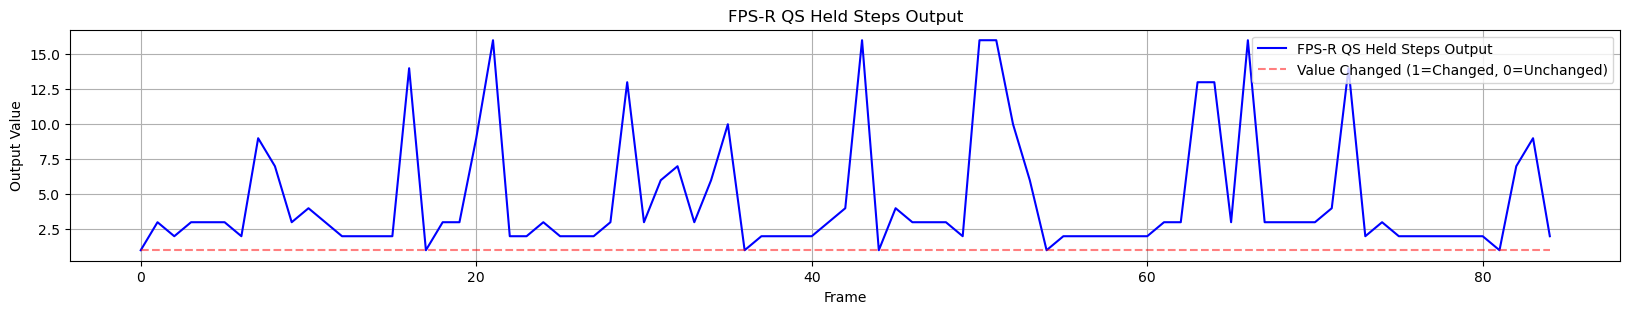

In [129]:
# output the changed steps list
held_steps = held_steps_list(values_changed)
# print(held_steps)
plot_values(held_steps, [1]*len(held_steps), seq_name='FPS-R QS Held Steps')

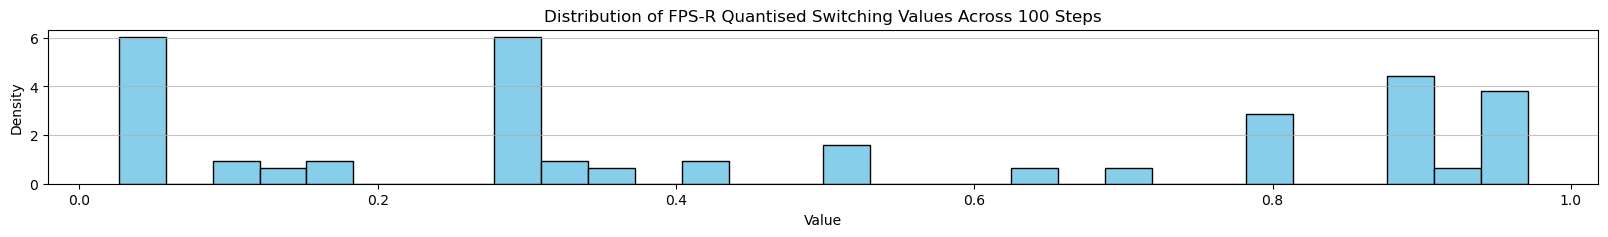

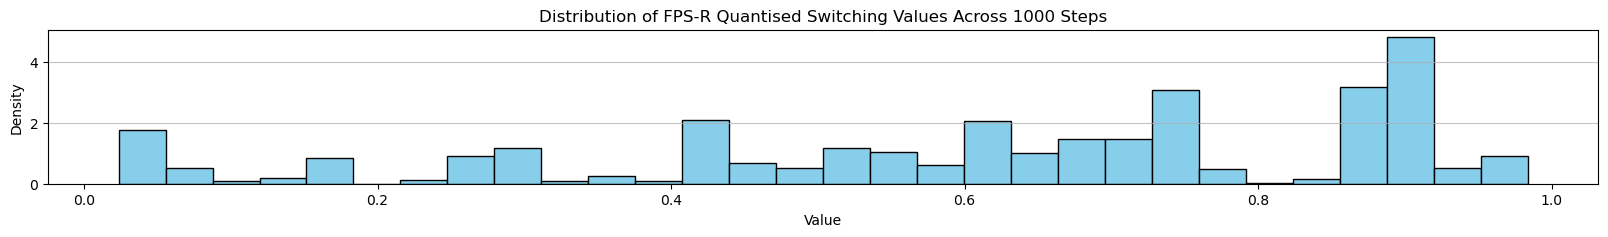

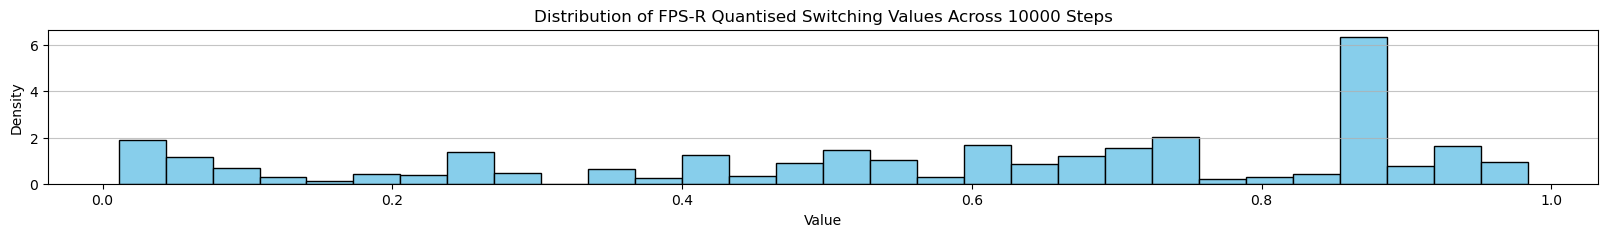

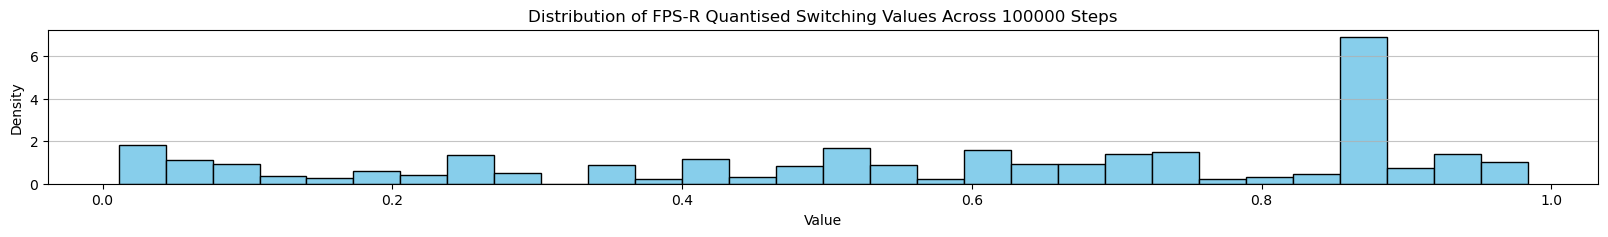

In [130]:
# Distribution Plot for QS
# seq_func points to the supplied function
seq_func = seq_qs
seq_name = 'FPS-R Quantised Switching'

for frame_count in distri_progressive_steps:
    plot_distribution(seq_func(frame_count), seq_name)
# The distribution of FPS-R QS values show a consistent pattern across different sample sizes.

## Plot FPS-R BD

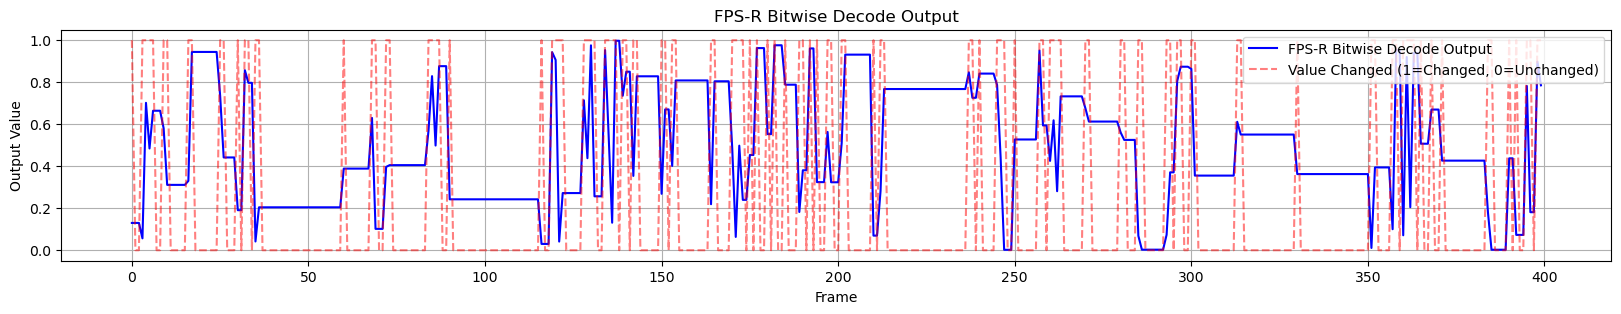

In [131]:
# calling fpsr_bd
values, values_changed = seq_bd(400)
# Plot the distribution of FPS-R BD values
plot_values(values, values_changed, seq_name='FPS-R Bitwise Decode')

FPS-R BD: Number of Steps Held Before the Next Jump

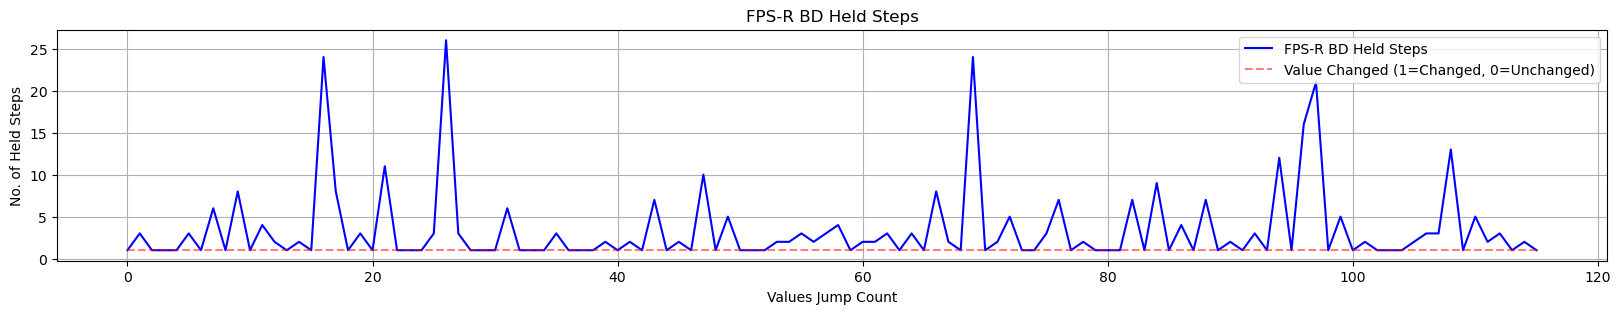

In [132]:
# output the changed steps list
held_steps = held_steps_list(values_changed)
# print(held_steps)
held_step_values(held_steps, [1]*len(held_steps), seq_name='FPS-R BD')

## Plot FPS-R BD Distribution Graphs

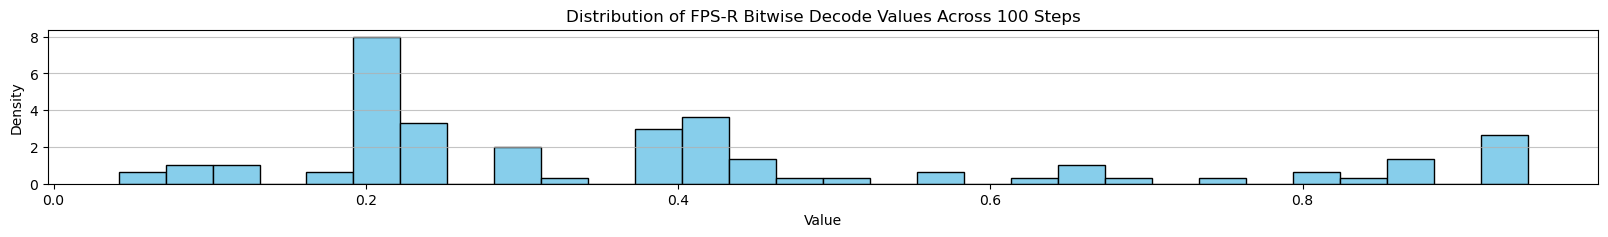

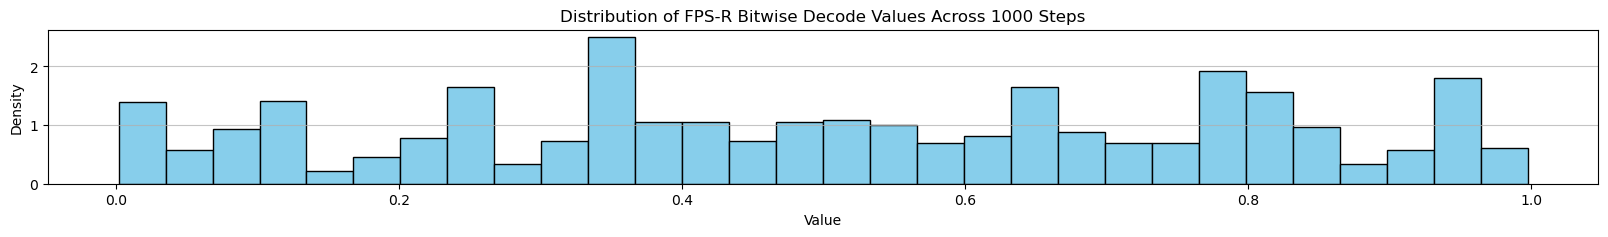

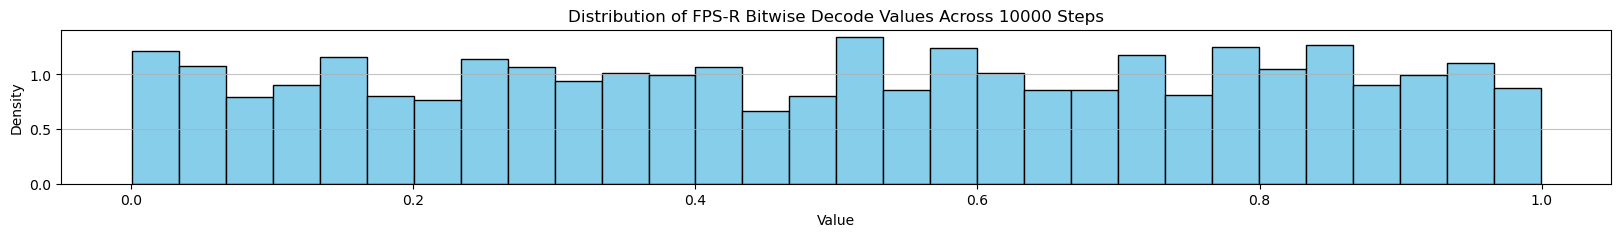

In [ ]:
# Distribution Plot for BD
# seq_func points to the supplied function
seq_func = seq_bd
seq_name = 'FPS-R Bitwise Decode'

for frame_count in distri_progressive_steps:
    plot_distribution(seq_func(frame_count), seq_name)
# The distribution of FPS-R BD values show a consistent pattern across different sample sizes.

### FPS-R: Stacked Modulo in a Plot
The code below generates an interactive scrollable sample output of **FPS-R: SM**, interactively scrollable for your inspection pleasure.

### FPS-R: Toggled Modulo in a Plot
The code below generates an interactive scrollable sample output of **FPS-R: TM**, interactively scrollable for your inspection pleasure.

### FPS-R: Quantised Switching in a Plot
The code below generates an interactive scrollable sample output of **FPS-R: QS**, interactively scrollable for your inspection pleasure.

### FPS-R: Bitwise Decode in a Plot
The code below generates an interactive scrollable sample output of **FPS-R: BD**, interactively scrollable for your inspection pleasure.

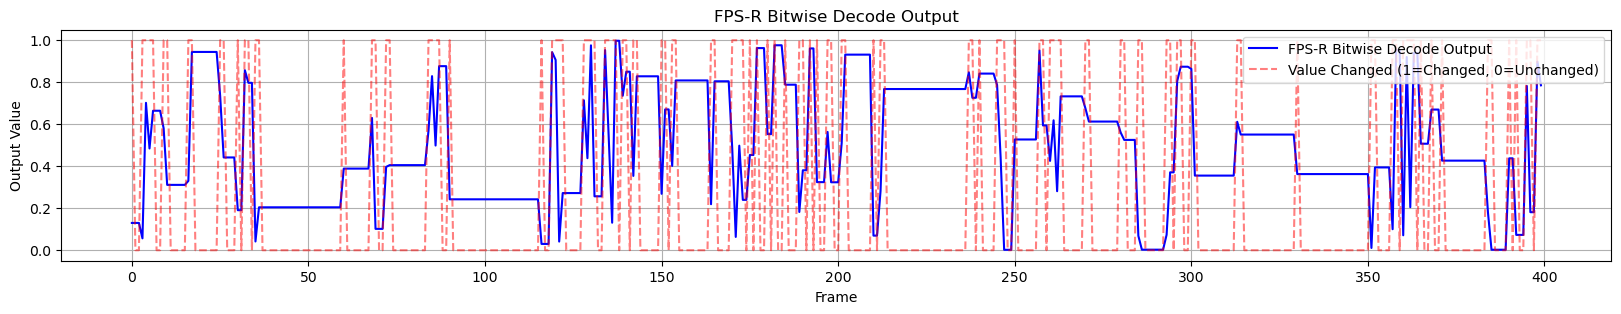

In [ ]:
# calling fpsr_bd
values, values_changed = seq_bd(400)
# Plot the distribution of FPS-R BD values
plot_values(values, values_changed, seq_name='FPS-R Bitwise Decode')

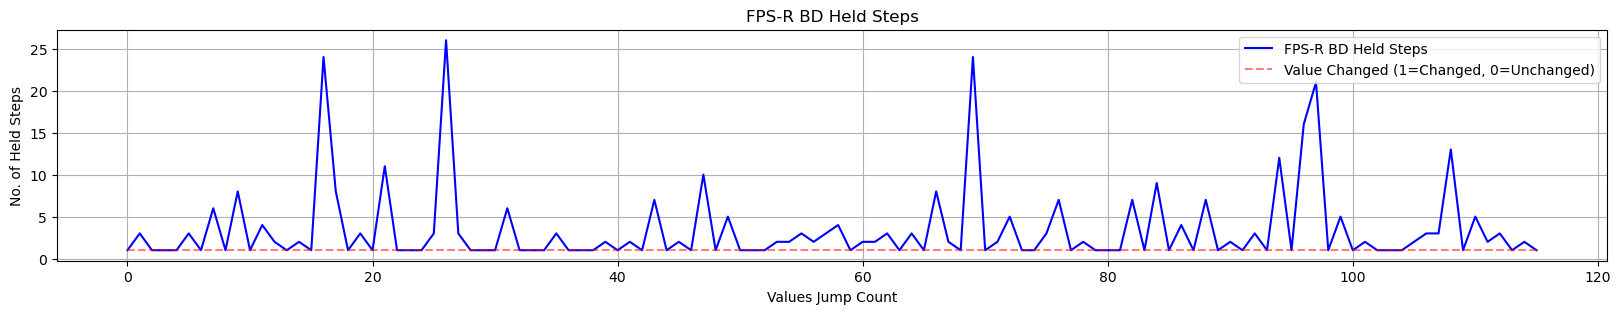

In [ ]:
# output the changed steps list
held_steps = held_steps_list(values_changed)
# print(held_steps)
held_step_values(held_steps, [1]*len(held_steps), seq_name='FPS-R BD')

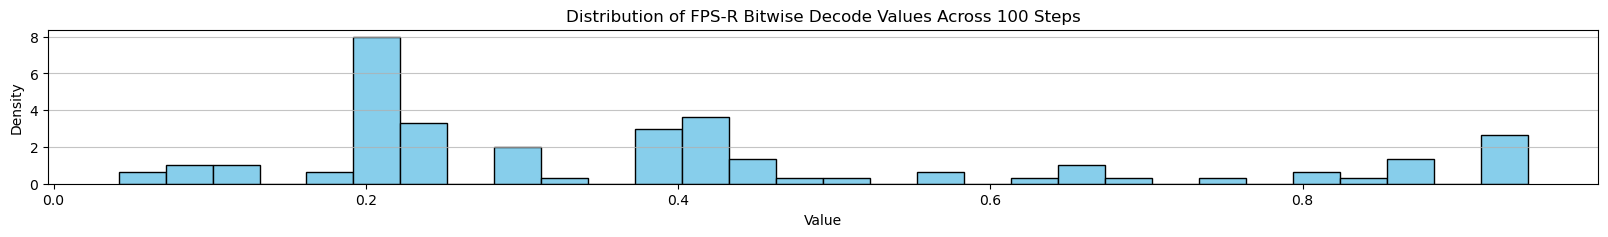

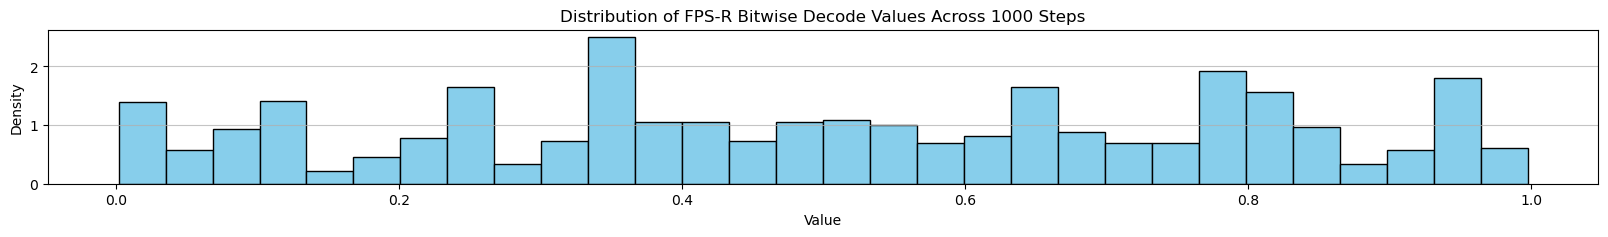

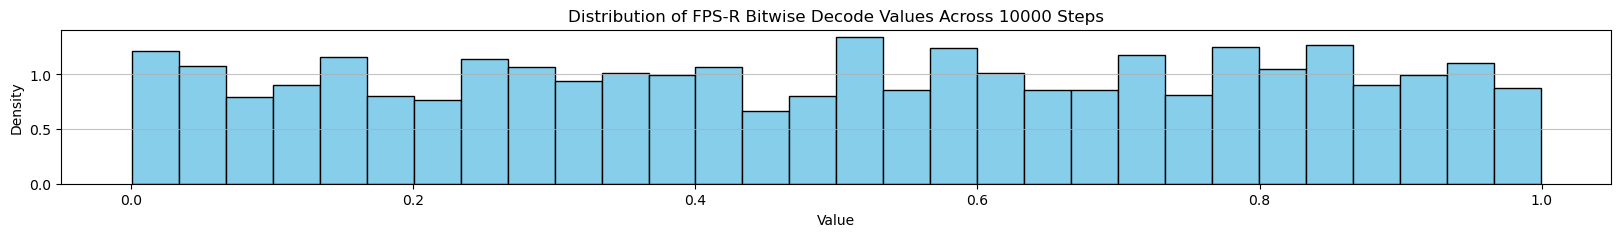

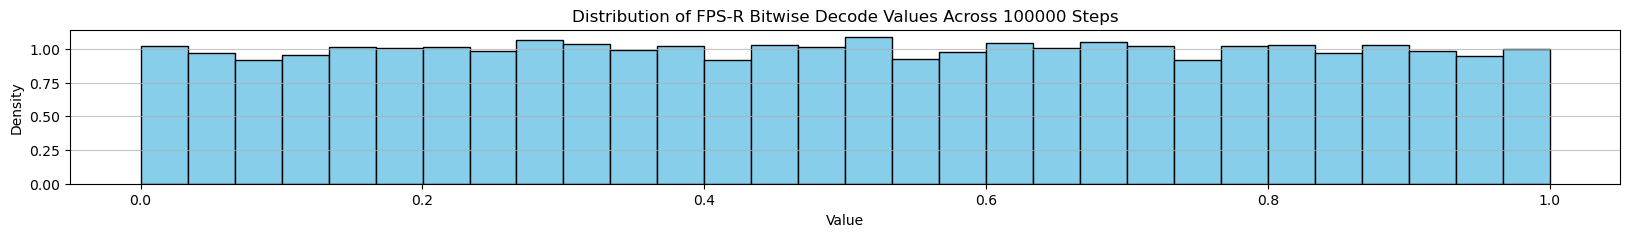

In [ ]:
# Distribution Plot for BD
# seq_func points to the supplied function
seq_func = seq_bd
seq_name = 'FPS-R Bitwise Decode'

for frame_count in distri_progressive_steps:
    plot_distribution(seq_func(frame_count), seq_name)
# The distribution of FPS-R BD values show a consistent pattern across different sample sizes.